# EDA

## Instalação e Importação de pacotes

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as c
#from mpl_toolkits.basemap import Basemap,shiftgrid
import pandas as pd
import netCDF4 as nc
from itertools import chain
from netCDF4 import Dataset
from netCDF4 import date2index
from datetime import datetime
import scipy
import geopy
import xarray
import networkx
import requests
import cartopy
import tropycal

import tropycal.tracks as tracks
import tropycal.tornado as tornado
import datetime as dt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import math
from scipy.special import gamma
import seaborn as sns
sns.set()
alpha = 0.5
#import csv
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Extração, Transformação, Carregamento e Limpeza dos Dados

In [6]:
# Referência para os dados: https://www.kaggle.com/noaa/hurricane-database
# O foco principal do trabalho se dará nos dados do atlântico
data_atl = pd.read_csv('../Datasets/atlantic.csv')

In [8]:
# formatando dados de data
data_atl['Date_c'] = pd.to_datetime(data_atl['Date'].astype(str), format='%Y%m%d')
data_atl['Year'] = pd.DatetimeIndex(data_atl['Date_c']).year
data_atl['Month'] = pd.DatetimeIndex(data_atl['Date_c']).month
data_atl['Day'] = pd.DatetimeIndex(data_atl['Date_c']).day
print(data_atl.columns)
data_atl.head()

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW',
       'Date_c', 'Year', 'Month', 'Day'],
      dtype='object')


ID                 Name      Date  Time Event Status Latitude  \
0  AL011851              UNNAMED  18510625     0           HU    28.0N   
1  AL011851              UNNAMED  18510625   600           HU    28.0N   
2  AL011851              UNNAMED  18510625  1200           HU    28.0N   
3  AL011851              UNNAMED  18510625  1800           HU    28.1N   
4  AL011851              UNNAMED  18510625  2100     L     HU    28.2N   

  Longitude  Maximum Wind  Minimum Pressure  ...  Moderate Wind SW  \
0     94.8W            80              -999  ...              -999   
1     95.4W            80              -999  ...              -999   
2     96.0W            80              -999  ...              -999   
3     96.5W            80              -999  ...              -999   
4     96.8W            80              -999  ...              -999   

   Moderate Wind NW  High Wind NE  High Wind SE  High Wind SW  High Wind NW  \
0              -999          -999          -999          -999          -999   
1              -999          -999          -999          -999          -999   
2              -999          -999          -999          -999          -999   
3              -999          -999          -999          -999          -999   
4              -999          -999          -999          -999          -999   

      Date_c  Year  Month  Day  
0 1851-06-25  1851      6   25  
1 1851-06-25  1851      6   25  
2 1851-06-25  1851      6   25  
3 1851-06-25  1851      6   25  
4 1851-06-25  1851      6   25  

[5 rows x 26 columns]

In [9]:
# Registro de Furacões é maior em determinada época do ano
print(data_atl.groupby(['Month'])['ID'].count())

Month
1       132
2        13
3        14
4        81
5       655
6      2349
7      3262
8     10857
9     18926
10     9802
11     2548
12      466
Name: ID, dtype: int64


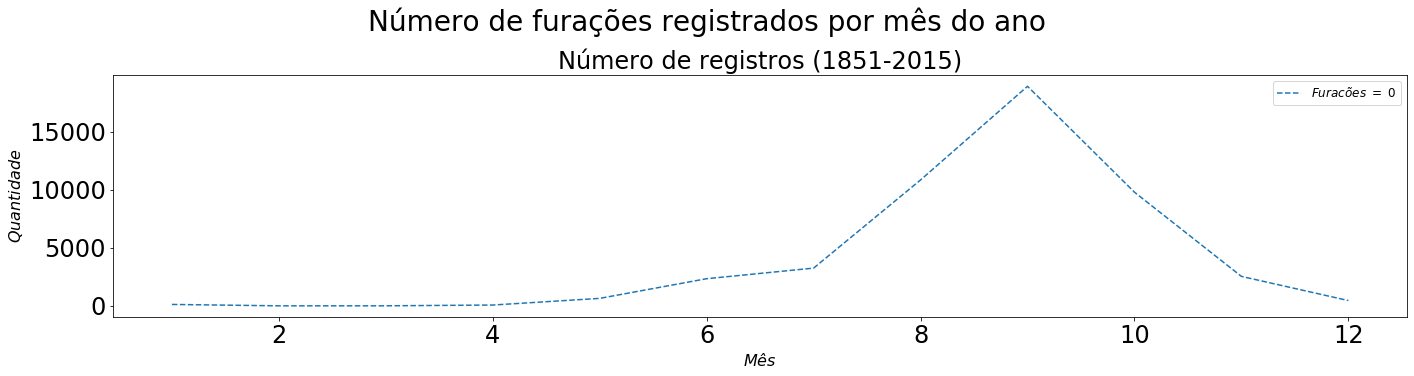

In [10]:
# Período de furacões se concentra entre os meses de julho e novembro.
# Isso deve estar relacionado com o período anterior (verão do hemisfério norte, onde acontece o maior número de casos)
# O aquecimento das águas está intimamente ligado com a formação das massas de ar que ocasionam os furacões
# Isso nos dá uma pista da forma de correlação temporal que devemos buscar para predizer os eventos

fig, ax = plt.subplots(2,1)#, figsize=(16,10))
fig.suptitle('Número de furações registrados por mês do ano', fontsize=28, y=1.06)

ax.plot(data_atl.groupby(['Month'])['Month'].mean(), data_atl.groupby(['Month'])['ID'].count(), ls = '--', label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Número de registros (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Mês$', fontsize=16)
ax.set_ylabel(r'$Quantidade$', fontsize=16)
ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

In [11]:
data_atl_ext = data_atl.copy()
data_atl_mwmp = data_atl.copy()
data_atl_mw = data_atl.copy()

ind_nan_ext = []
ind_nan_mwmp = []
ind_nan_mw = []
for l in range(len(data_atl)):
    if (data_atl_mw['Maximum Wind'][l] < 0):
        ind_nan_mw.append(l)
        ind_nan_mwmp.append(l)
        ind_nan_ext.append(l)
    elif (data_atl_mwmp['Minimum Pressure'][l] < 0):
        ind_nan_mwmp.append(l)
        ind_nan_ext.append(l)
    elif (min(data_atl_ext['Low Wind NE'][l], data_atl_ext['Low Wind SE'][l], data_atl_ext['Low Wind SW'][l], data_atl_ext['Low Wind NW'][l], data_atl_ext['Moderate Wind NE'][l], data_atl_ext['Moderate Wind SE'][l], data_atl_ext['Moderate Wind SW'][l], data_atl_ext['Moderate Wind NW'][l], data_atl_ext['High Wind NE'][l], data_atl_ext['High Wind SE'][l], data_atl_ext['High Wind SW'][l], data_atl_ext['High Wind NW'][l]) < 0):
        ind_nan_ext.append(l)
data_atl_ext = data_atl_ext.drop(ind_nan_ext, 0)
data_atl_mwmp = data_atl_mwmp.drop(ind_nan_mwmp, 0)
data_atl_mw = data_atl_mw.drop(ind_nan_mw, 0)

print(len(data_atl_ext))
print(len(data_atl_mwmp))
print(len(data_atl_mw))

5921
18436
48767


No handles with labels found to put in legend.


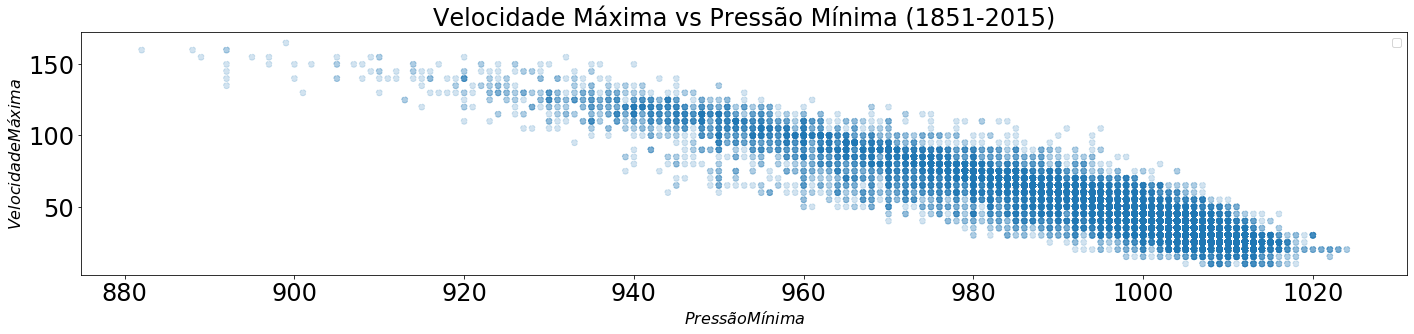

In [12]:
fig, ax = plt.subplots(1,1)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax.scatter(data_atl_mwmp['Minimum Pressure'], data_atl_mwmp['Maximum Wind'], alpha = 0.2, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Pressão Mínima$', fontsize=16)
ax.set_ylabel(r'$Velocidade Máxima$', fontsize=16)
ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

In [13]:
def format_lat(latitude):
    new_lat = []
    for lat in latitude:
        if lat[-1]=="N":
            new_lat.append(float(lat[0:-1]))
        else:
            new_lat.append(-float(lat[0:-1]))
    return new_lat

def format_lon(longitude):
    new_lon = []
    for lon in longitude:
        if lon[-1]=="E":
            new_lon.append(float(lon[0:-1]))
        else:
            new_lon.append(-float(lon[0:-1]))
    return new_lon

#format_lat(data_atl['Latitude'])
data_atl['Latitude_c'] = format_lat(data_atl['Latitude'])
data_atl['Longitude_c'] = format_lat(data_atl['Longitude'])

# Todas as Latitudes são menores que 0, e as Longitudes maiores que 0
#print(data_atl[data_atl['Latitude_c'] < 0])
#print(data_atl[data_atl['Longitude_c'] > 0])

No handles with labels found to put in legend.


R^2_train = 0.40918060978408977
Parâmetro_const  = -3940.3491393512004
Parâmetro_Year  = 2.192423797184305


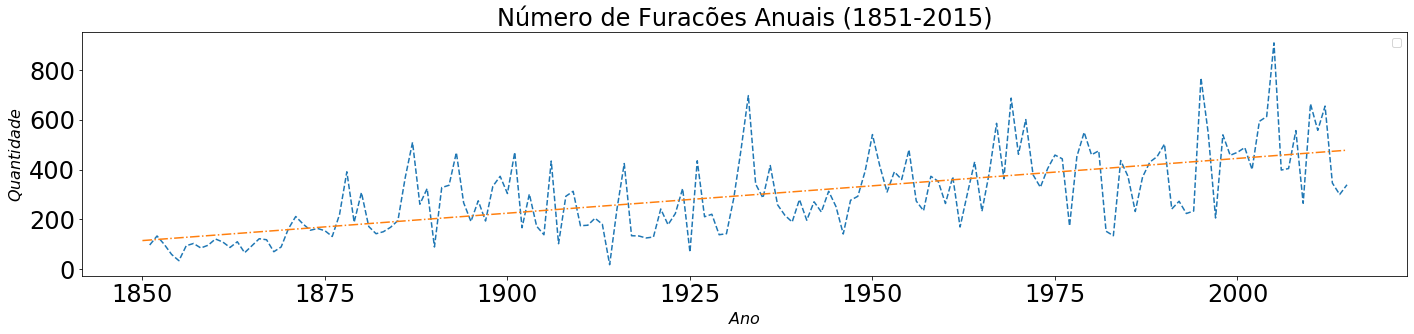

In [14]:
#Número de registro de furações tem crescido, mas isso se deve à maior capacidade de detecção com o passar dos anos
X_train = data_atl.groupby(['Year'])['Year'].mean()
y_train = data_atl.groupby(['Year'])['ID'].count()
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared
#r2_test = 1 - ((OLSModel.predict(X_test2)-y_test)*(OLSModel.predict(X_test2)-y_test)).sum() / ((y_test.mean()-y_test)*(y_test.mean()-y_test)).sum()
print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax.plot(data_atl.groupby(['Year'])['ID'].count(), ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax.plot([1850, 2015], [w0, w1], ls = '-.') #, label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Número de Furacões Anuais (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Quantidade$', fontsize=16)
ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

#plt.plot(data_atl.groupby(['Year'])['ID'].count())

No handles with labels found to put in legend.


R^2_train = 0.49772308255924613
Parâmetro_const  = 345.35295844916755
Parâmetro_Year  = -0.15025433346159117


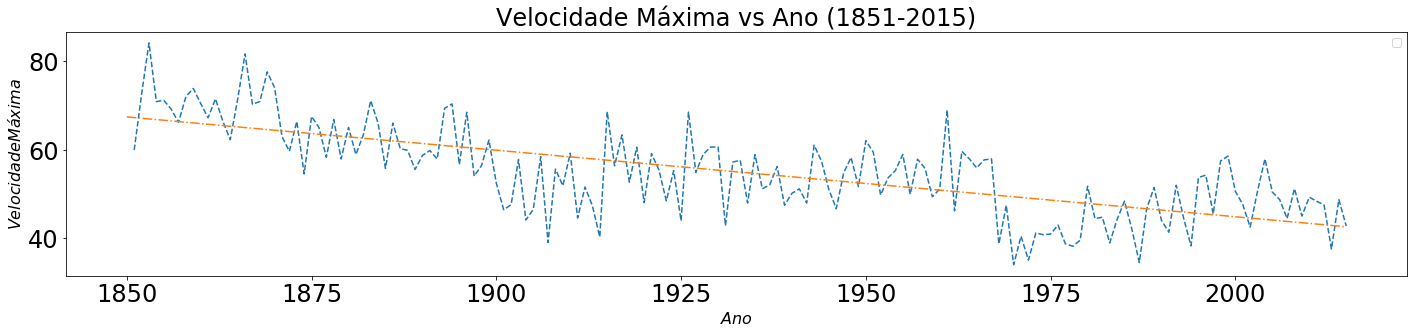

In [15]:
#Velocidade máxima de vento sustentada pelos furacões reduziu, mas isso também se deve à maior capacidade de registro 
#de eventos de pequeno porte
X_train = data_atl_mw.groupby(['Year'])['Year'].mean()
y_train = data_atl_mw.groupby(['Year'])['Maximum Wind'].mean()
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared
#r2_test = 1 - ((OLSModel.predict(X_test2)-y_test)*(OLSModel.predict(X_test2)-y_test)).sum() / ((y_test.mean()-y_test)*(y_test.mean()-y_test)).sum()
print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax.plot(data_atl_mw.groupby(['Year'])['Year'].mean(), data_atl_mw.groupby(['Year'])['Maximum Wind'].mean(), ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax.plot([1850, 2015], [w0, w1], ls = '-.') #, label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Velocidade Máxima vs Ano (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Velocidade Máxima$', fontsize=16)
ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

#plt.plot(data_atl_mw.groupby(['Year'])['Year'].mean(), data_atl_mw.groupby(['Year'])['Maximum Wind'].mean())

In [16]:
#Para não enviesar nossos dados, filtraremos os registros de pequeno porte
data_atl_fdur = data_atl_mw.copy()
duration = data_atl_mw.groupby(['ID'])['Date_c'].max()-data_atl_mw.groupby(['ID'])['Date_c'].min()
duration.name = 'Duration'
#print(duration)
data_atl_fdur = pd.merge(data_atl_fdur, duration, how='inner', left_on='ID', right_index=True)
data_atl_fdur['Duration'] = pd.to_numeric(data_atl_fdur['Duration'].dt.days, downcast='integer')
data_atl_fdur = data_atl_fdur[data_atl_fdur['Duration'] > 2]
print(len(data_atl_fdur))


46350


In [18]:
#Para não enviesar nossos dados, filtraremos os registros de pequeno porte (somente a partir de Tropical Storm)
data_atl_fwind = data_atl_fdur.copy()
data_atl_fwind = data_atl_fwind[data_atl_fwind['Maximum Wind'] > 34]
print(len(data_atl_fwind))

35696


No handles with labels found to put in legend.


R^2_train = 0.15573477903937416
Parâmetro_const  = -1661.4327723310093
Parâmetro_Year  = 0.9714289530628062


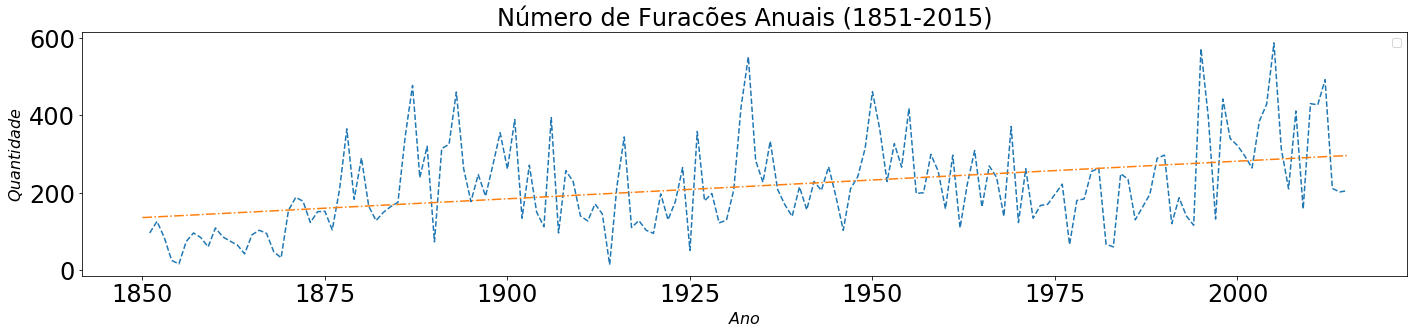

In [19]:
# Com o novo filtro, o viés do aumento no número de furacões ao longo dos anos reduziu, mas ainda há um aumento
# Isso mostra que essa tendência pode ser algo não viesada, e que gera preocupação pelo futuro
X_train = data_atl_fwind.groupby(['Year'])['Year'].mean()
y_train = data_atl_fwind.groupby(['Year'])['ID'].count()
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared
#r2_test = 1 - ((OLSModel.predict(X_test2)-y_test)*(OLSModel.predict(X_test2)-y_test)).sum() / ((y_test.mean()-y_test)*(y_test.mean()-y_test)).sum()
print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax.plot(data_atl_fwind.groupby(['Year'])['ID'].count(), ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax.plot([1850, 2015], [w0, w1], ls = '-.') #, label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Número de Furacões Anuais (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Quantidade$', fontsize=16)
ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

No handles with labels found to put in legend.


R^2_train = 0.11158706746149893
Parâmetro_const  = 167.44362825887168
Parâmetro_Year  = -0.054709821748082546


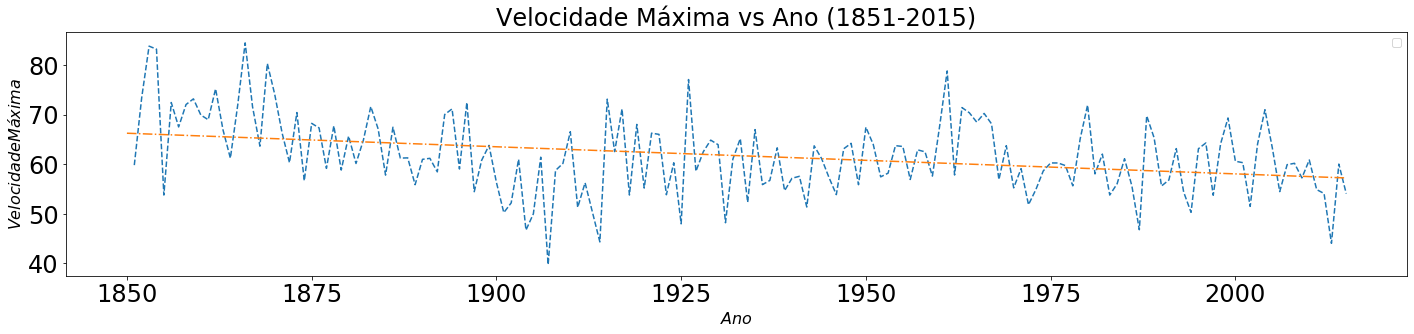

In [30]:
# Com o novo filtro, o viés da redução da velocidade máxima sustentada de vento reduziu, quase para o nível constante
# Isso pode significar que os filtros estão relativamente bem adequados para retirada do viés inicial dos dados
X_train = data_atl_fwind.groupby(['Year'])['Year'].mean()
y_train = data_atl_fwind.groupby(['Year'])['Maximum Wind'].mean()
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared
#r2_test = 1 - ((OLSModel.predict(X_test2)-y_test)*(OLSModel.predict(X_test2)-y_test)).sum() / ((y_test.mean()-y_test)*(y_test.mean()-y_test)).sum()
print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax.plot(data_atl_fwind.groupby(['Year'])['Year'].mean(), data_atl_fwind.groupby(['Year'])['Maximum Wind'].mean(), ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax.plot([1850, 2015], [w0, w1], ls = '-.') #, label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Velocidade Máxima vs Ano (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Velocidade Máxima$', fontsize=16)
ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

#plt.plot(data_atl_mw.groupby(['Year'])['Year'].mean(), data_atl_mw.groupby(['Year'])['Maximum Wind'].mean())

In [25]:
data_atl_mw2 = data_atl_mw.copy()
data_atl_mw2['Latitude_c'] = format_lat(data_atl_mw['Latitude'])
data_atl_mw2['Longitude_c'] = format_lat(data_atl_mw['Longitude'])
data_atl_mw2.head()

ID                 Name      Date  Time Event Status Latitude  \
0  AL011851              UNNAMED  18510625     0           HU    28.0N   
1  AL011851              UNNAMED  18510625   600           HU    28.0N   
2  AL011851              UNNAMED  18510625  1200           HU    28.0N   
3  AL011851              UNNAMED  18510625  1800           HU    28.1N   
4  AL011851              UNNAMED  18510625  2100     L     HU    28.2N   

  Longitude  Maximum Wind  Minimum Pressure  ...  High Wind NE  High Wind SE  \
0     94.8W            80              -999  ...          -999          -999   
1     95.4W            80              -999  ...          -999          -999   
2     96.0W            80              -999  ...          -999          -999   
3     96.5W            80              -999  ...          -999          -999   
4     96.8W            80              -999  ...          -999          -999   

   High Wind SW  High Wind NW     Date_c  Year  Month  Day  Latitude_c  \
0          -999          -999 1851-06-25  1851      6   25        28.0   
1          -999          -999 1851-06-25  1851      6   25        28.0   
2          -999          -999 1851-06-25  1851      6   25        28.0   
3          -999          -999 1851-06-25  1851      6   25        28.1   
4          -999          -999 1851-06-25  1851      6   25        28.2   

   Longitude_c  
0        -94.8  
1        -95.4  
2        -96.0  
3        -96.5  
4        -96.8  

[5 rows x 28 columns]

In [26]:
#print(data_atl_mw2.groupby(['ID'], as_index=False)['ID', 'Latitude_c'].first())
data_atl_mw2_filtrado3 = data_atl_mw2.copy()
Lat_min = data_atl_mw2_filtrado3.groupby(['ID'])['Latitude_c'].first()
Lat_min.name = 'Lat_min'
#print(Lat_min)
data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, Lat_min, how='inner', left_on='ID', right_index=True)
#print(data_atl_mw2_filtrado3)
data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[abs(data_atl_mw2_filtrado3['Lat_min'] - 12.5) > 0]
#data_atl_mw2_filtrado3.head()

Lon_min = data_atl_mw2_filtrado3.groupby(['ID'])['Longitude_c'].min()
Lon_min.name = 'Lon_min'
#print(Lon_min)
data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, Lon_min, how='inner', left_on='ID', right_index=True)
#print(data_atl_mw2_filtrado3)
data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Lon_min'] > -180]

Wind_max = data_atl_mw2_filtrado3.groupby(['ID'])['Maximum Wind'].max()
Wind_max.name = 'Wind_max'
#print(Wind_max)
data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, Wind_max, how='inner', on='ID')#left_on='ID', right_index=True)
#print(data_atl_mw2_filtrado3)
data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Wind_max'] > 34]

data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Year'] > 1950]

duration = data_atl_mw2_filtrado3.groupby(['ID'])['Date_c'].max()-data_atl_mw2_filtrado3.groupby(['ID'])['Date_c'].min()
duration.name = 'Duration'
#print(duration)
data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, duration, how='inner', left_on='ID', right_index=True)
data_atl_mw2_filtrado3['Duration'] = pd.to_numeric(data_atl_mw2_filtrado3['Duration'].dt.days, downcast='integer')
data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Duration'] > 2]

data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3.drop(['Lat_min', 'Lon_min', 'Wind_max'], 1)
#data_atl_mw2_filtrado3.head()

print(len(data_atl_mw2_filtrado3))
print(len(data_atl.groupby(['ID'])['ID'].count()))
print(len(data_atl_mw2_filtrado3.groupby(['ID'])['ID'].count()))

print(len(data_atl))
print(len(data_atl_mw2))
data_atl_mw2_filtrado3.head()


22386
1814
685
49105
48767


ID                 Name      Date  Time Event Status Latitude  \
21948  AL011951              UNNAMED  19510102  1200           EX    30.5N   
21949  AL011951              UNNAMED  19510102  1800           EX    29.9N   
21950  AL011951              UNNAMED  19510103     0           EX    29.0N   
21951  AL011951              UNNAMED  19510103   600           EX    27.5N   
21952  AL011951              UNNAMED  19510103  1200           EX    26.5N   

      Longitude  Maximum Wind  Minimum Pressure  ...  High Wind SE  \
21948     58.0W            50              -999  ...          -999   
21949     56.8W            45              -999  ...          -999   
21950     55.7W            45              -999  ...          -999   
21951     54.8W            45              -999  ...          -999   
21952     54.5W            45              -999  ...          -999   

       High Wind SW  High Wind NW     Date_c  Year  Month  Day  Latitude_c  \
21948          -999          -999 1951-01-02  1951      1    2        30.5   
21949          -999          -999 1951-01-02  1951      1    2        29.9   
21950          -999          -999 1951-01-03  1951      1    3        29.0   
21951          -999          -999 1951-01-03  1951      1    3        27.5   
21952          -999          -999 1951-01-03  1951      1    3        26.5   

       Longitude_c  Duration  
21948        -58.0        10  
21949        -56.8        10  
21950        -55.7        10  
21951        -54.8        10  
21952        -54.5        10  

[5 rows x 29 columns]

In [27]:
data_atl_mw2_filtrado3.to_csv('data_atl_mw2_filtrado3.csv', encoding='utf-8', index=False)


## Outras Visualizações

Referência: https://tropycal.github.io/tropycal/examples/index.html

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (12.27 seconds)


C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\tropycal\tracks\storm.py:1239: UserWarning: Reading in tornado data for this storm. If you seek to analyze tornado data for multiple storms, run "TrackDataset.assign_storm_tornadoes()" to avoid this warning in the future.
  warnings.warn(warn_message)


--> Starting to read in tornado track data
--> Completed reading in tornado data for 1950-2018 (22.54 seconds)


C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Pleas

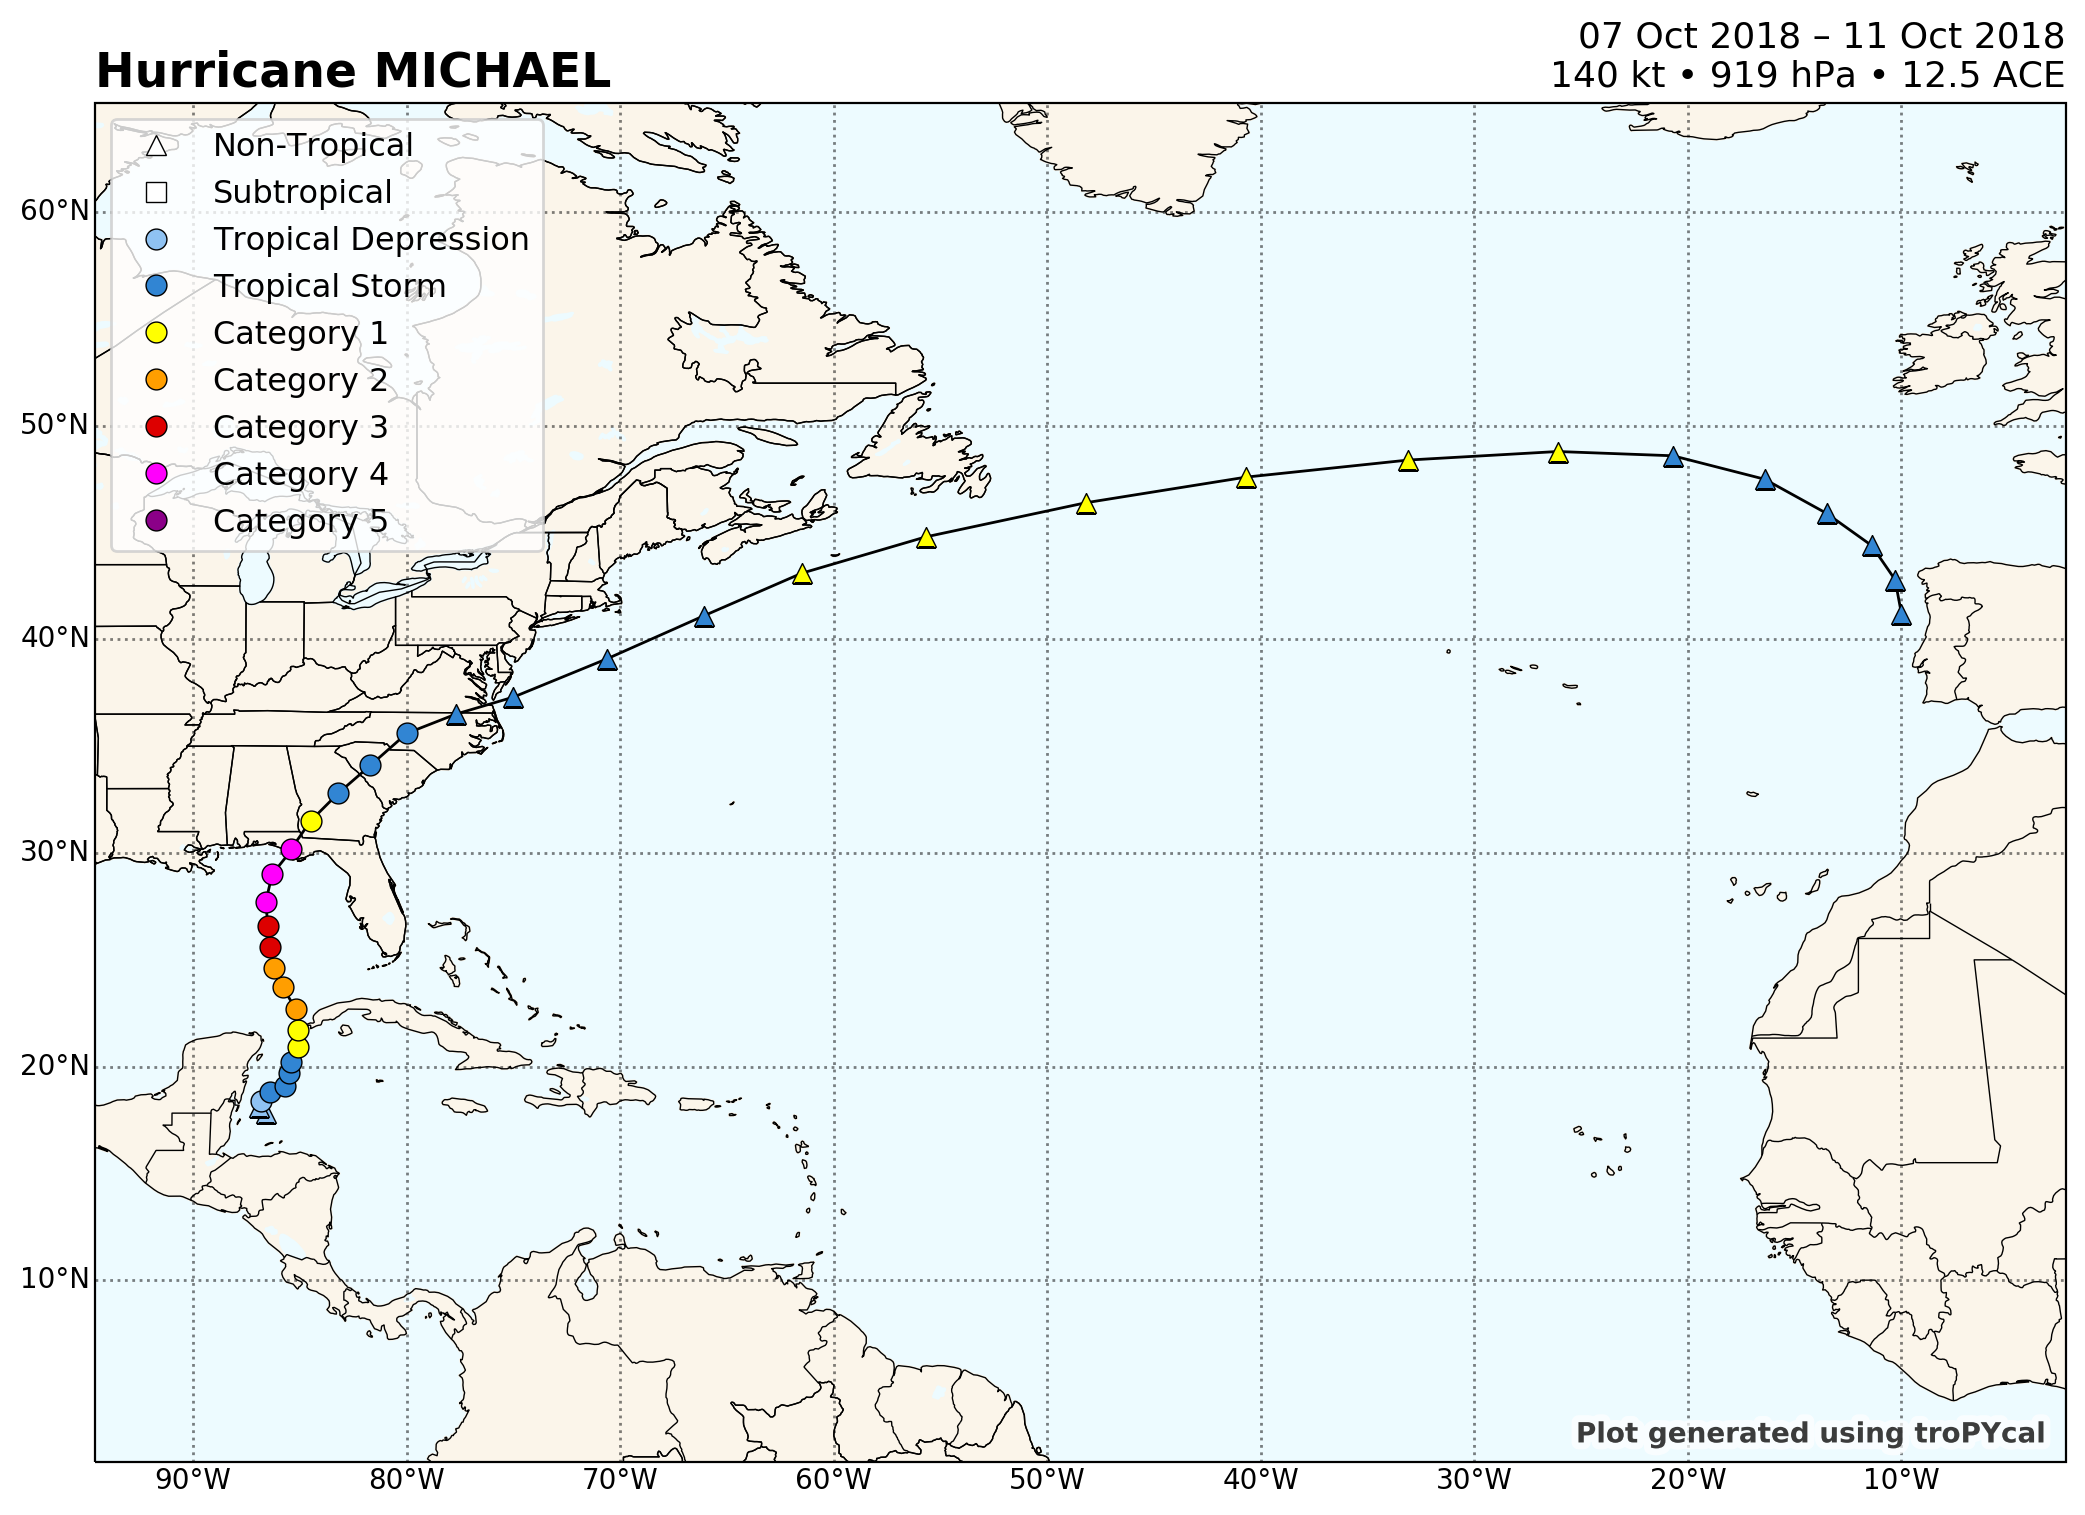

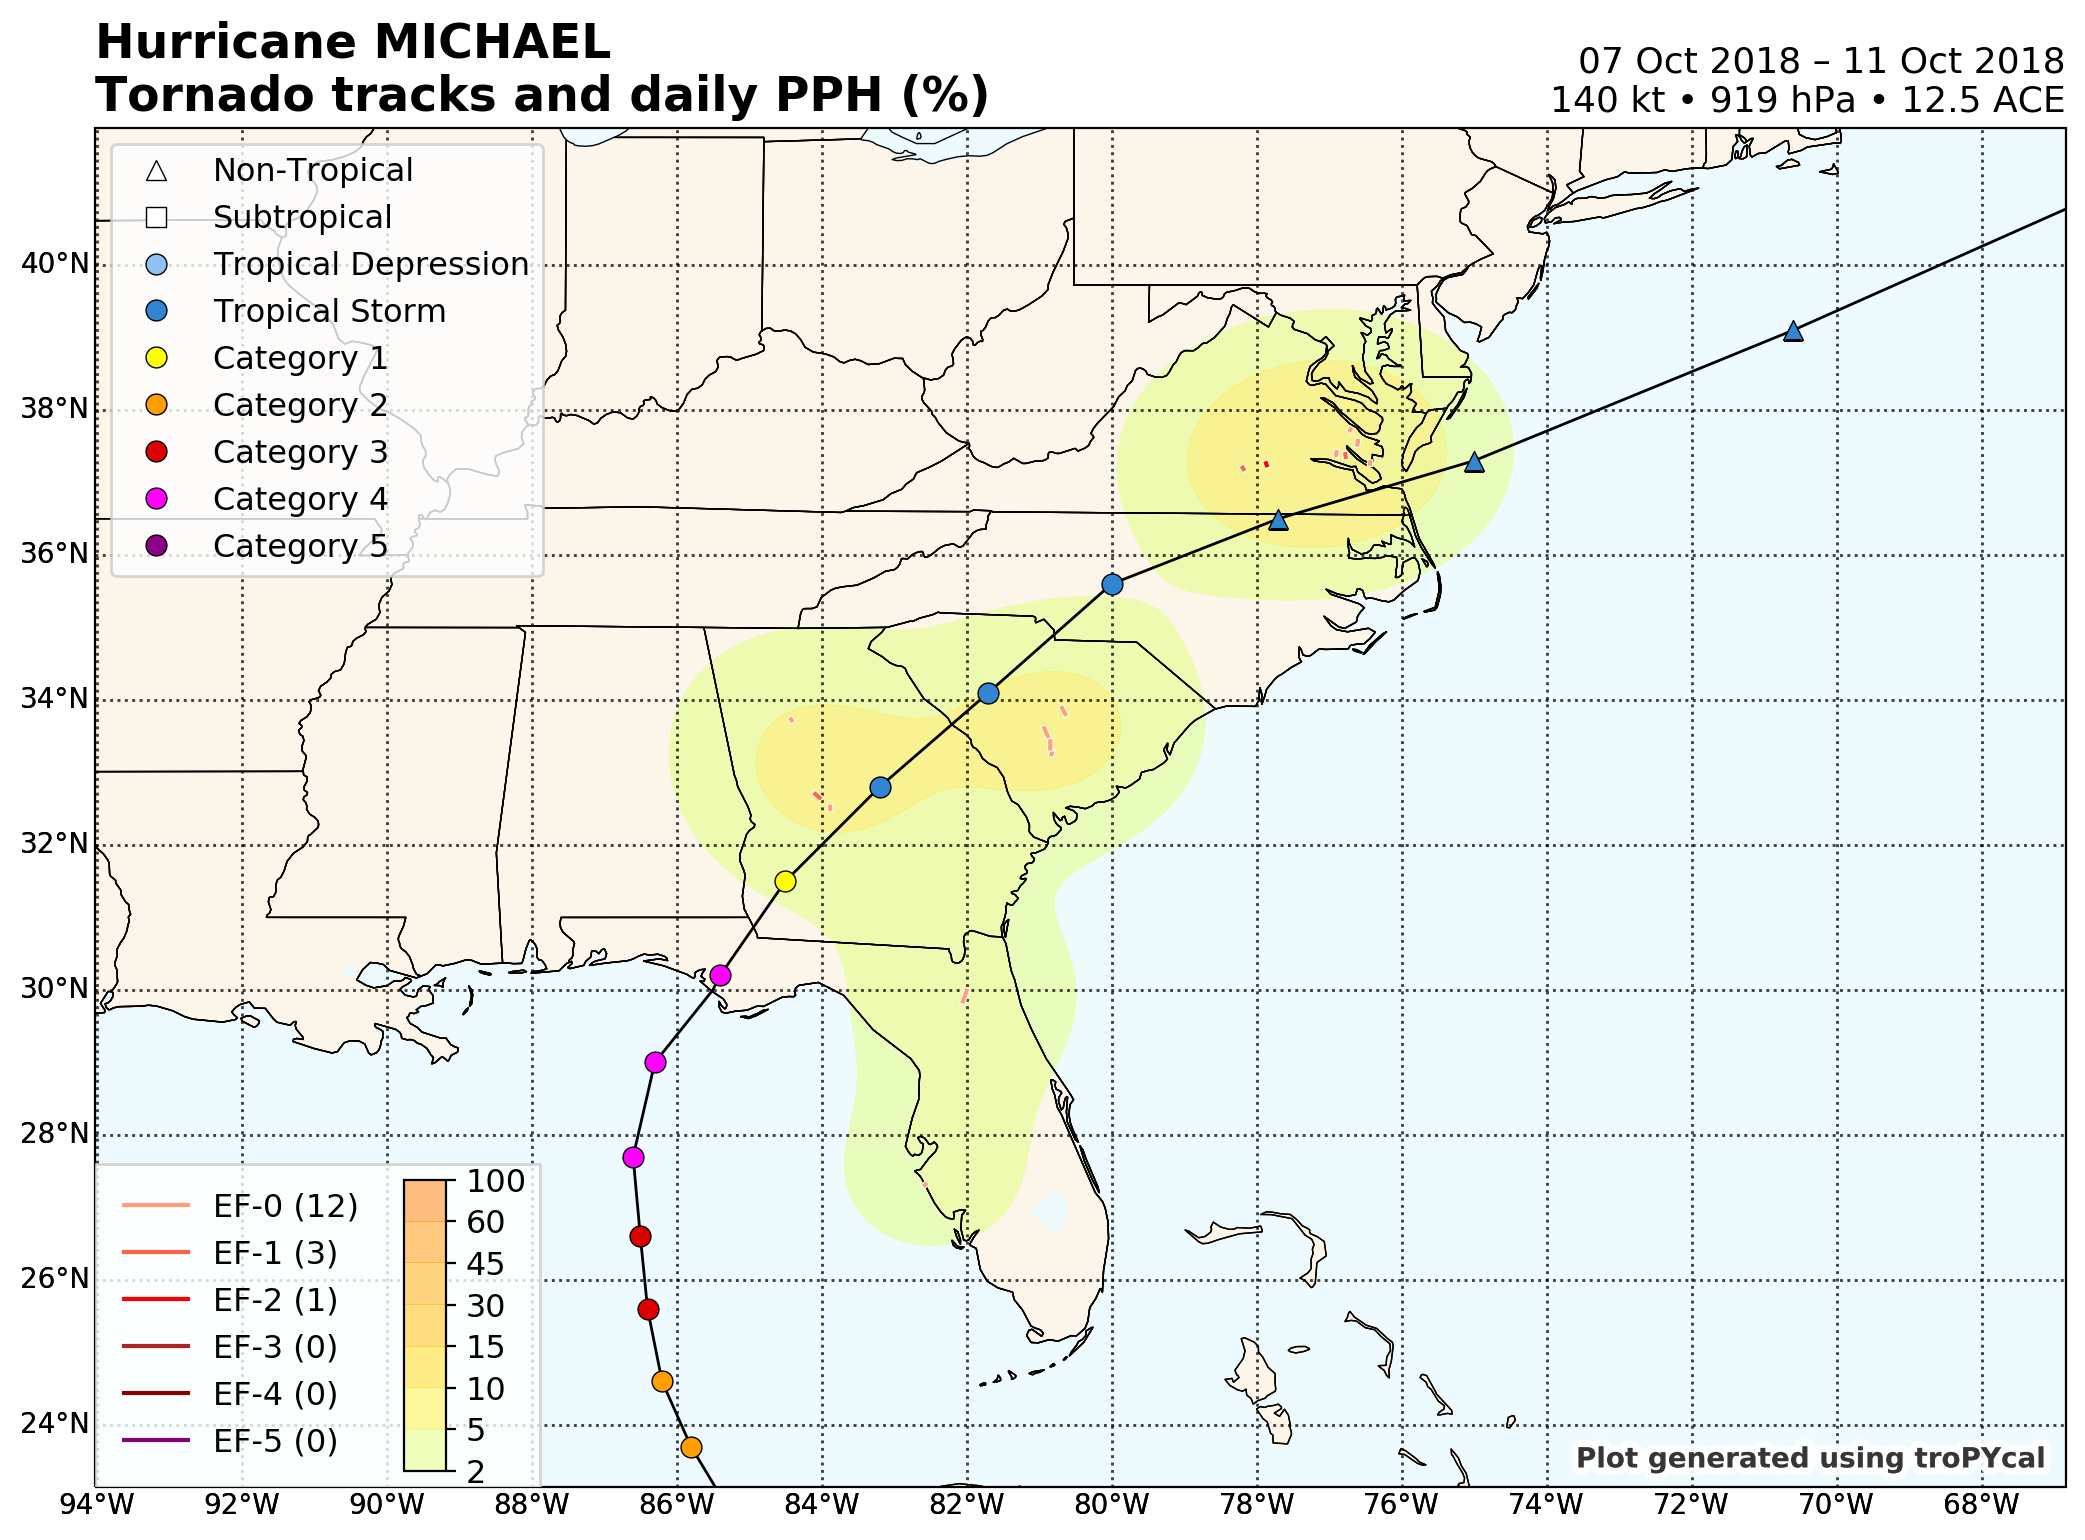

C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Pleas

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (269.28 seconds)


C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


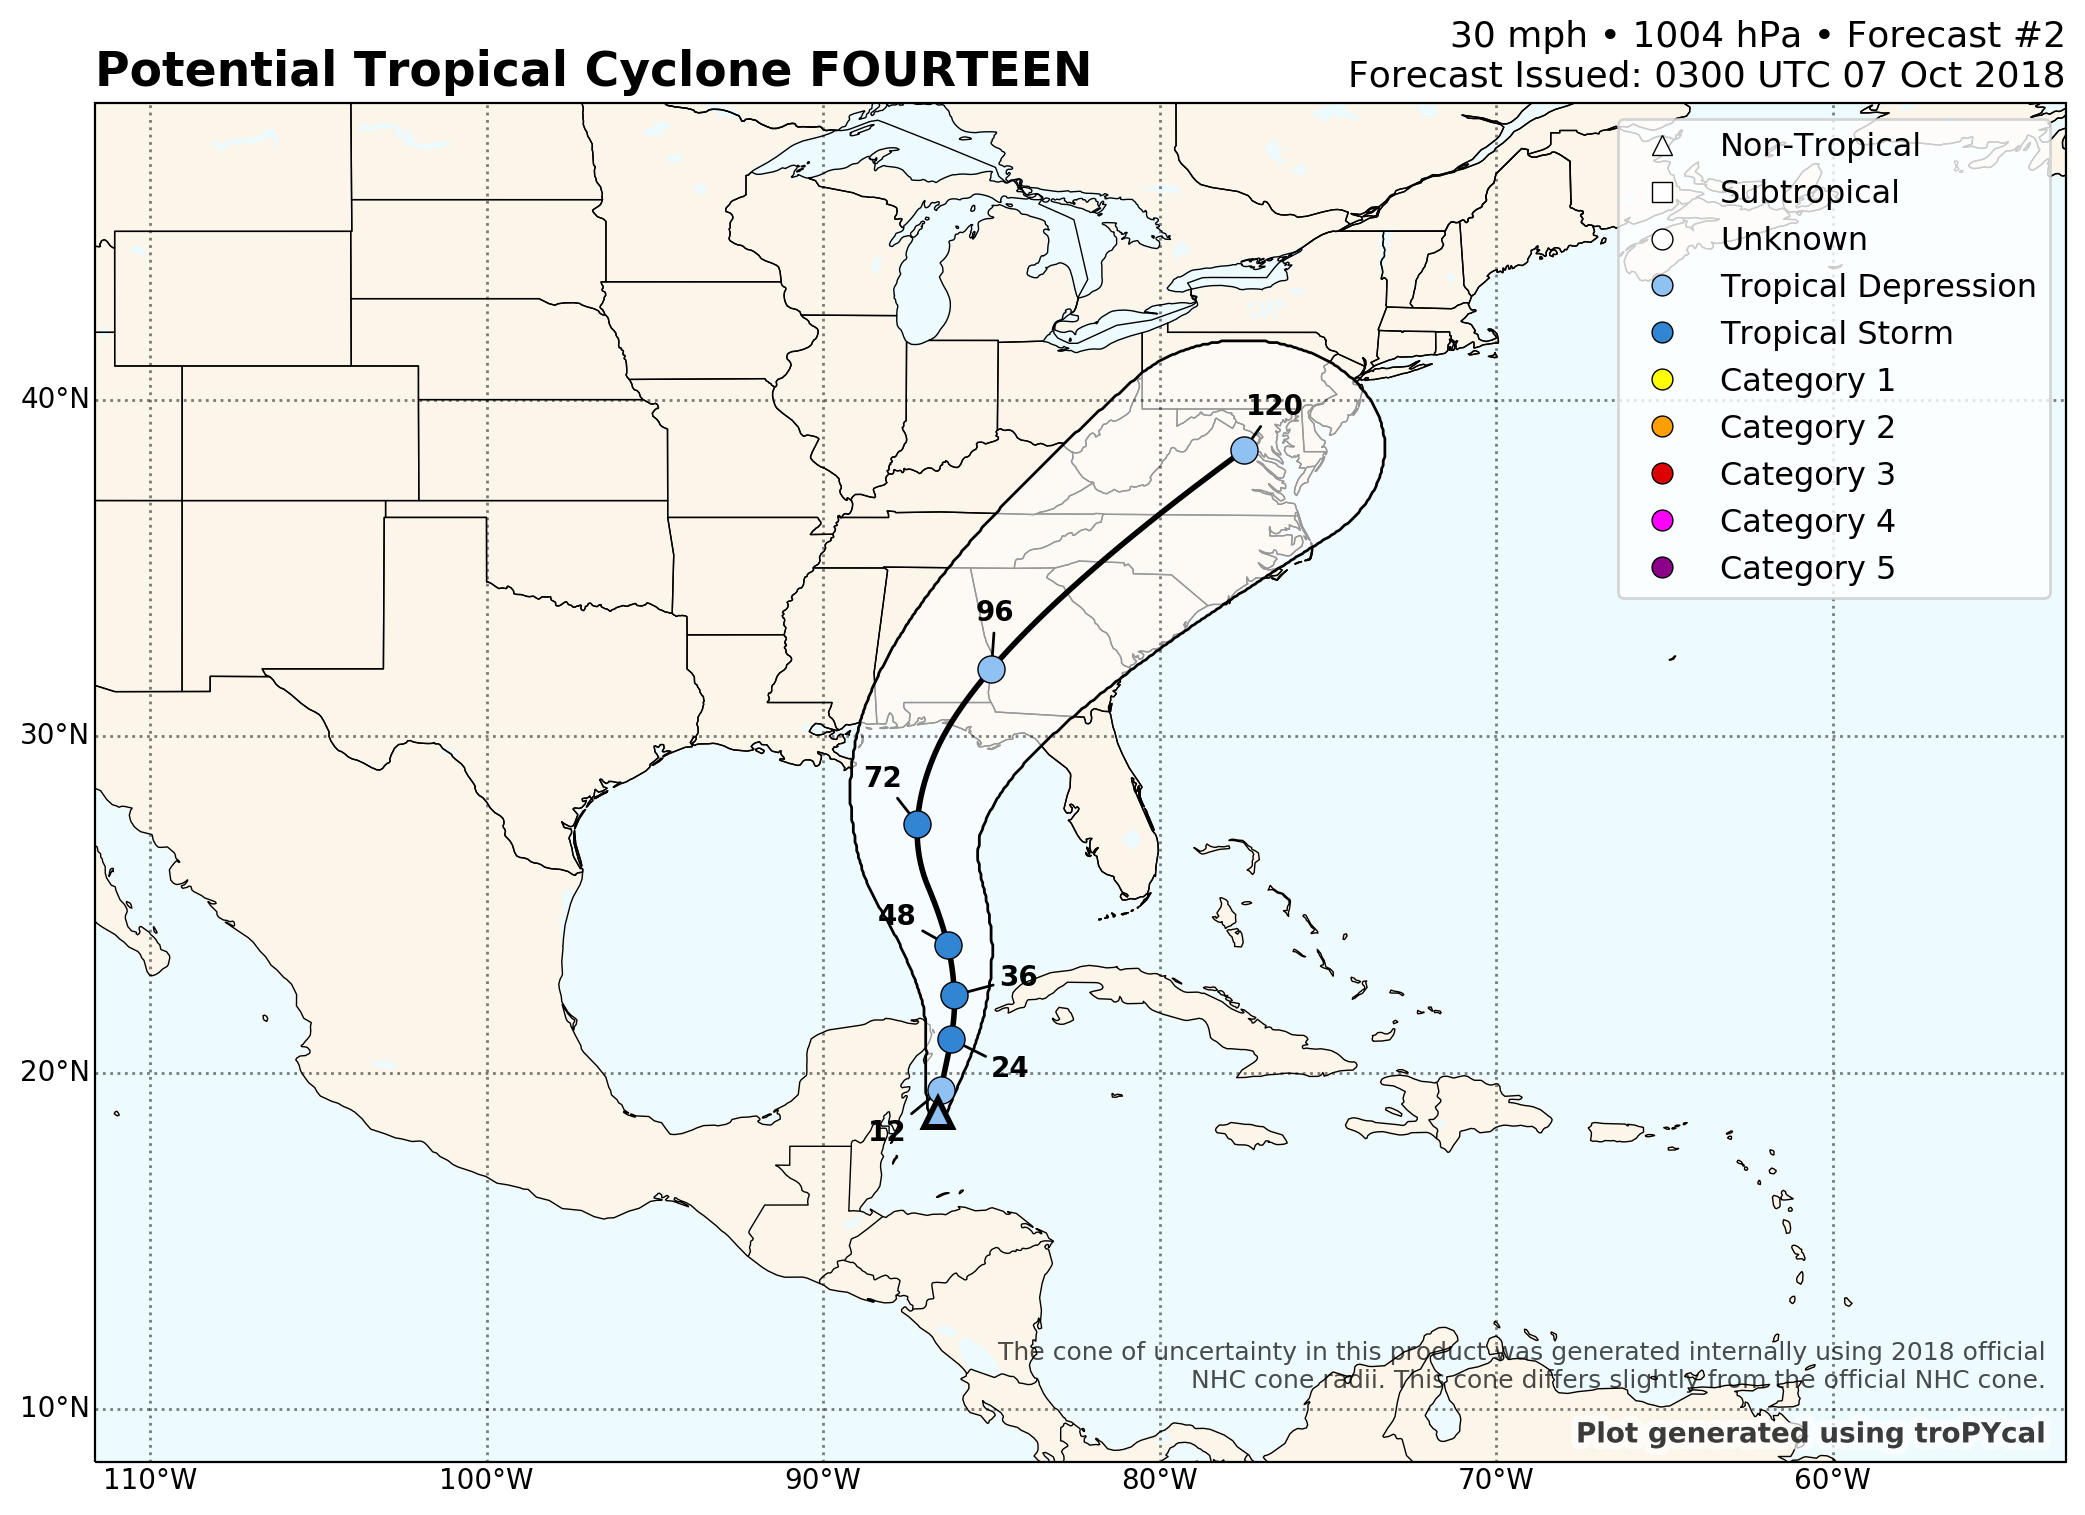

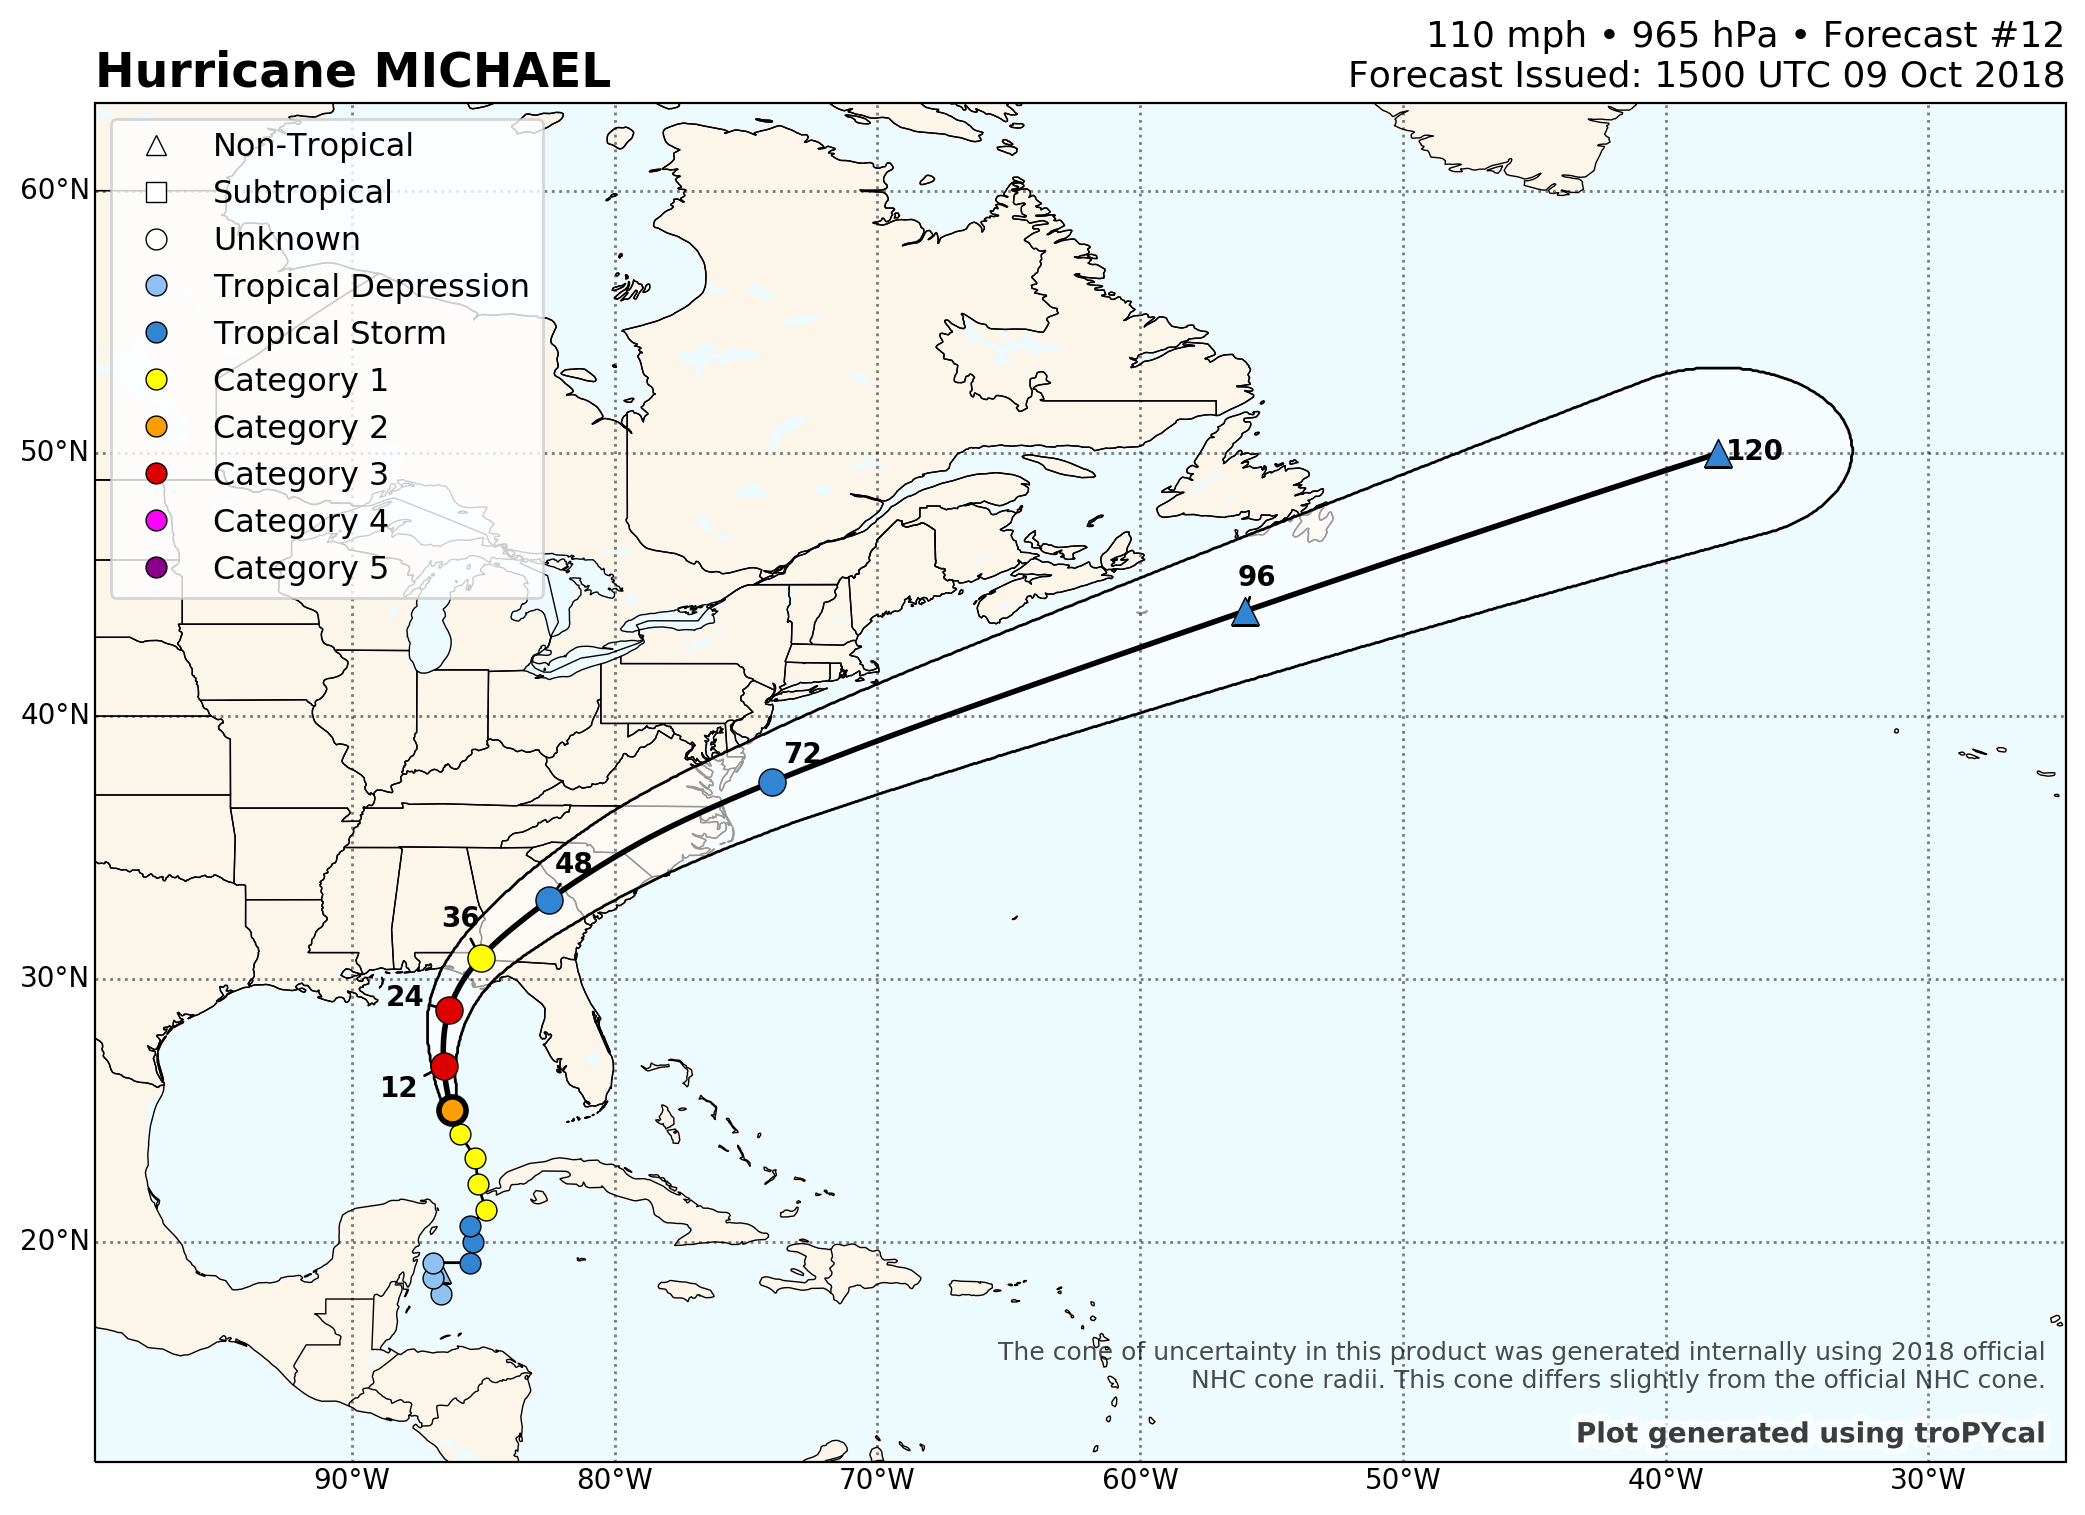

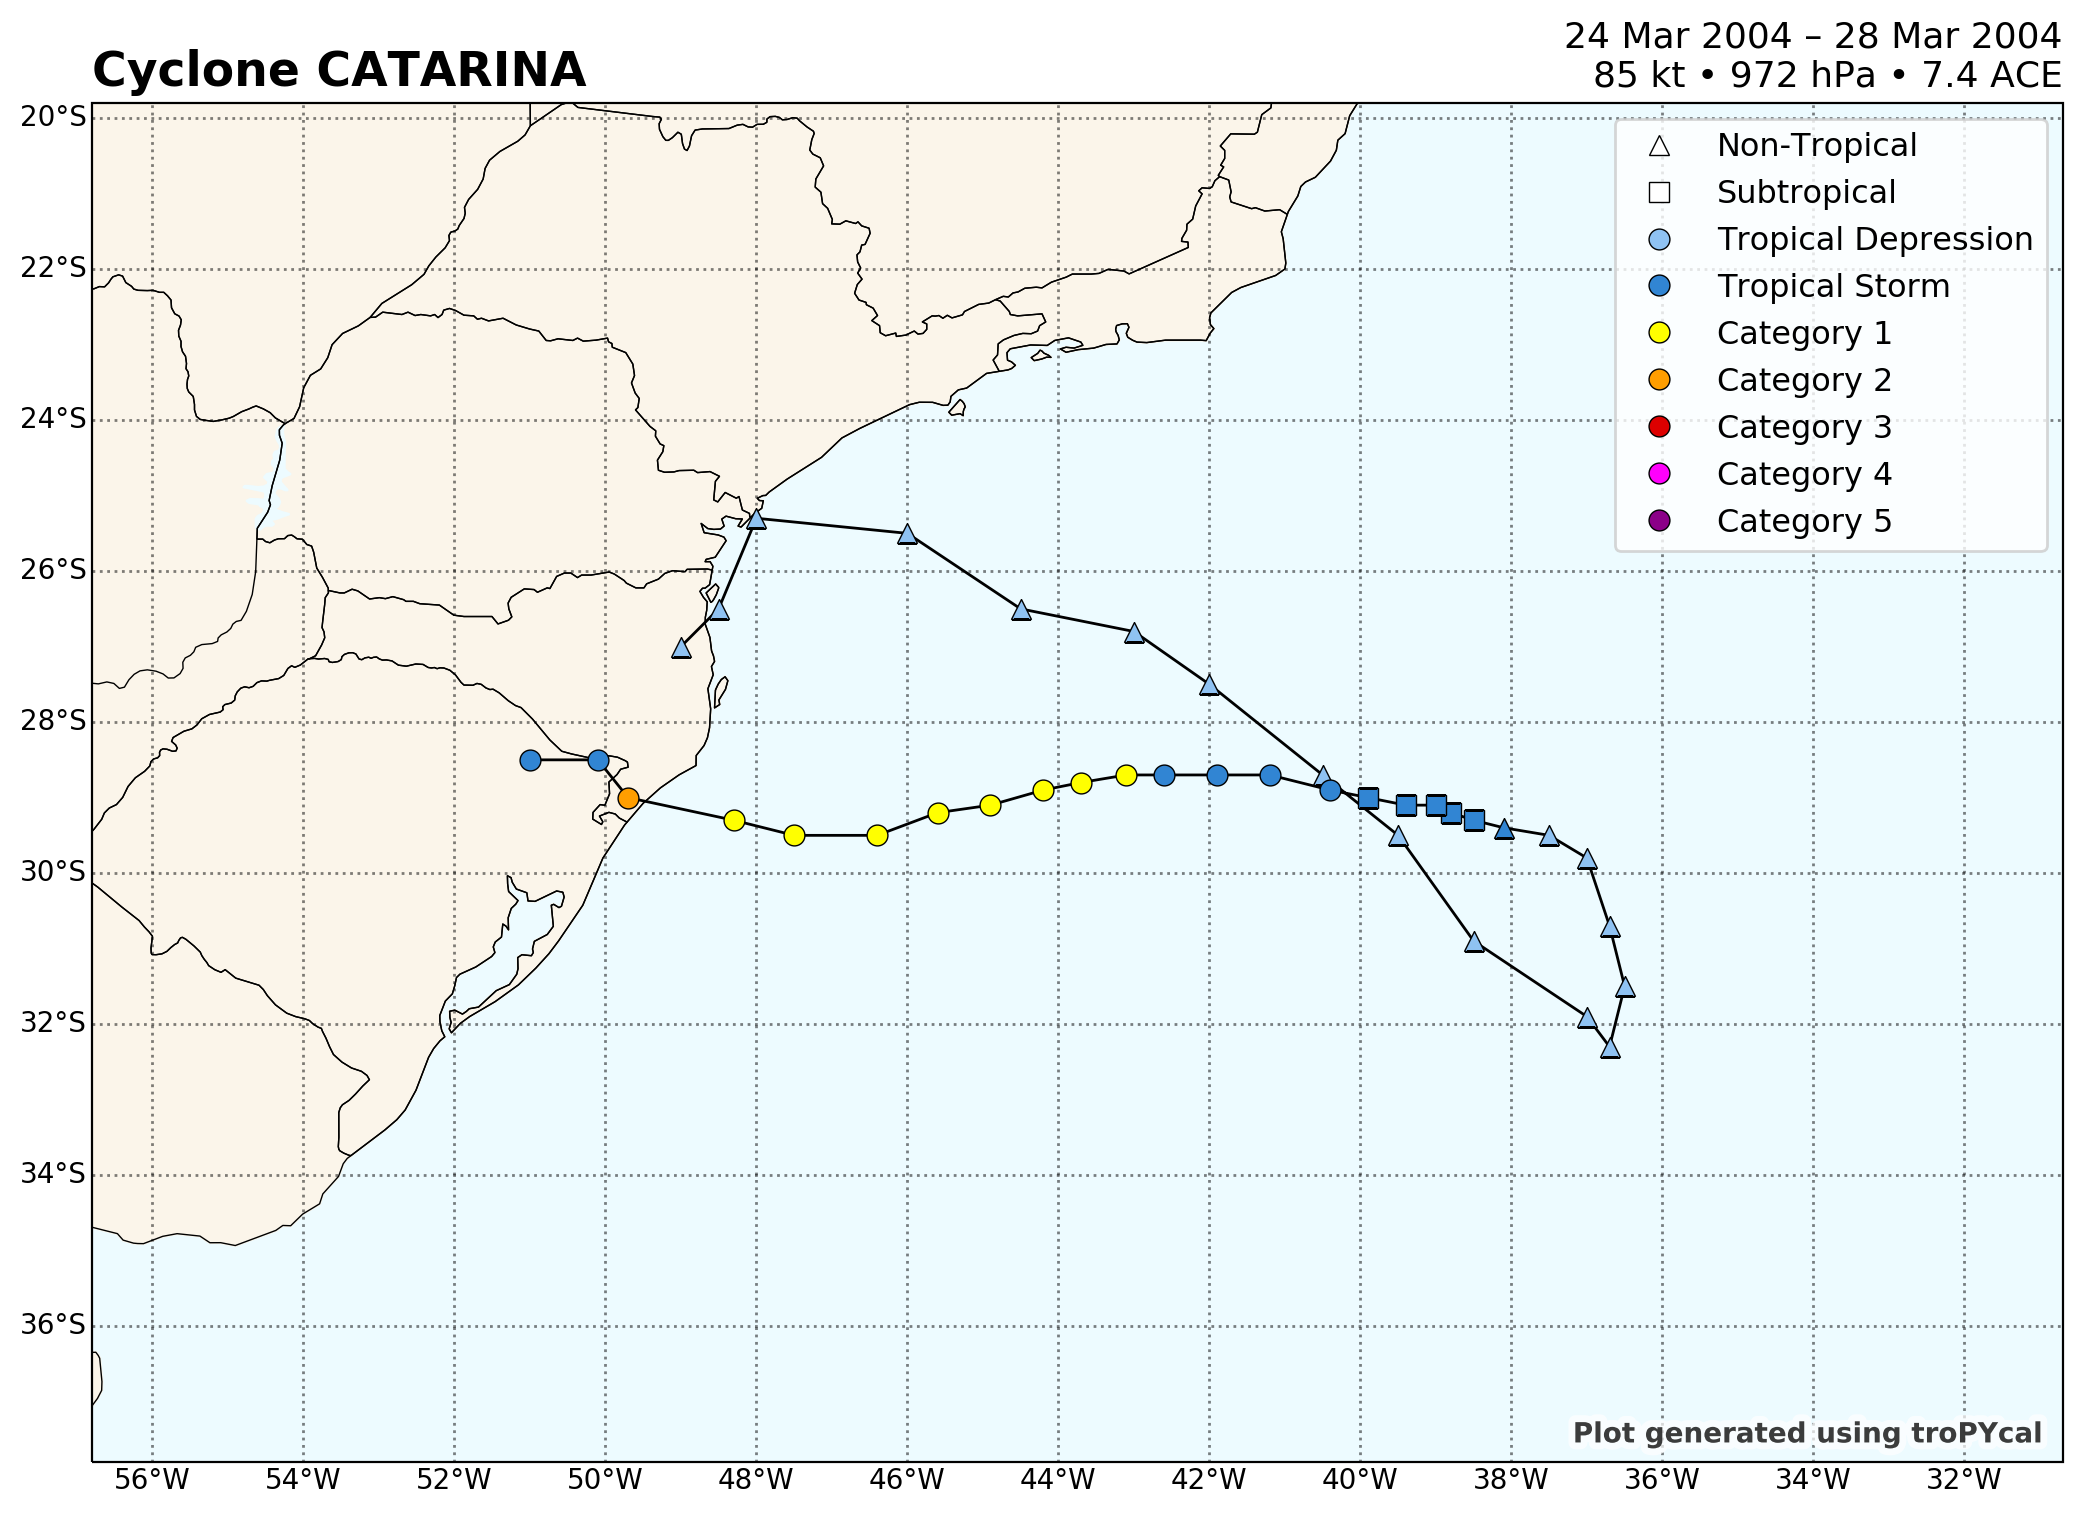

In [28]:
hurdat_atl = tracks.TrackDataset(basin='north_atlantic',source='hurdat',include_btk=False)

storm = hurdat_atl.get_storm(('michael',2018))

#
storm.plot(return_ax=True)
#
storm.plot_tors(plotPPH=True)
#
storm.plot_nhc_forecast(forecast=2,return_ax=True)
#
storm.plot_nhc_forecast(forecast=12,return_ax=True)
#
ibtracs = tracks.TrackDataset(basin='all',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True)
#
storm = ibtracs.get_storm(('catarina',2004))
storm.plot(return_ax=True)

--> Starting to read in tornado track data
--> Completed reading in tornado data for 1950-2018 (28.47 seconds)


C:\Users\User\anaconda3\lib\site-packages\tropycal\tornado\tools.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTors['SPC_time'] = dfTors['UTC_time'] - timedelta(hours=12)
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (8.9 seconds)
--> Starting to read in tornado track data
--> Completed reading in tornado data for 1950-2018 (17.77 seconds)
--> Starting to assign tornadoes to storms
--> Completed assigning tornadoes to storm (516.59 seconds)


C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Pleas

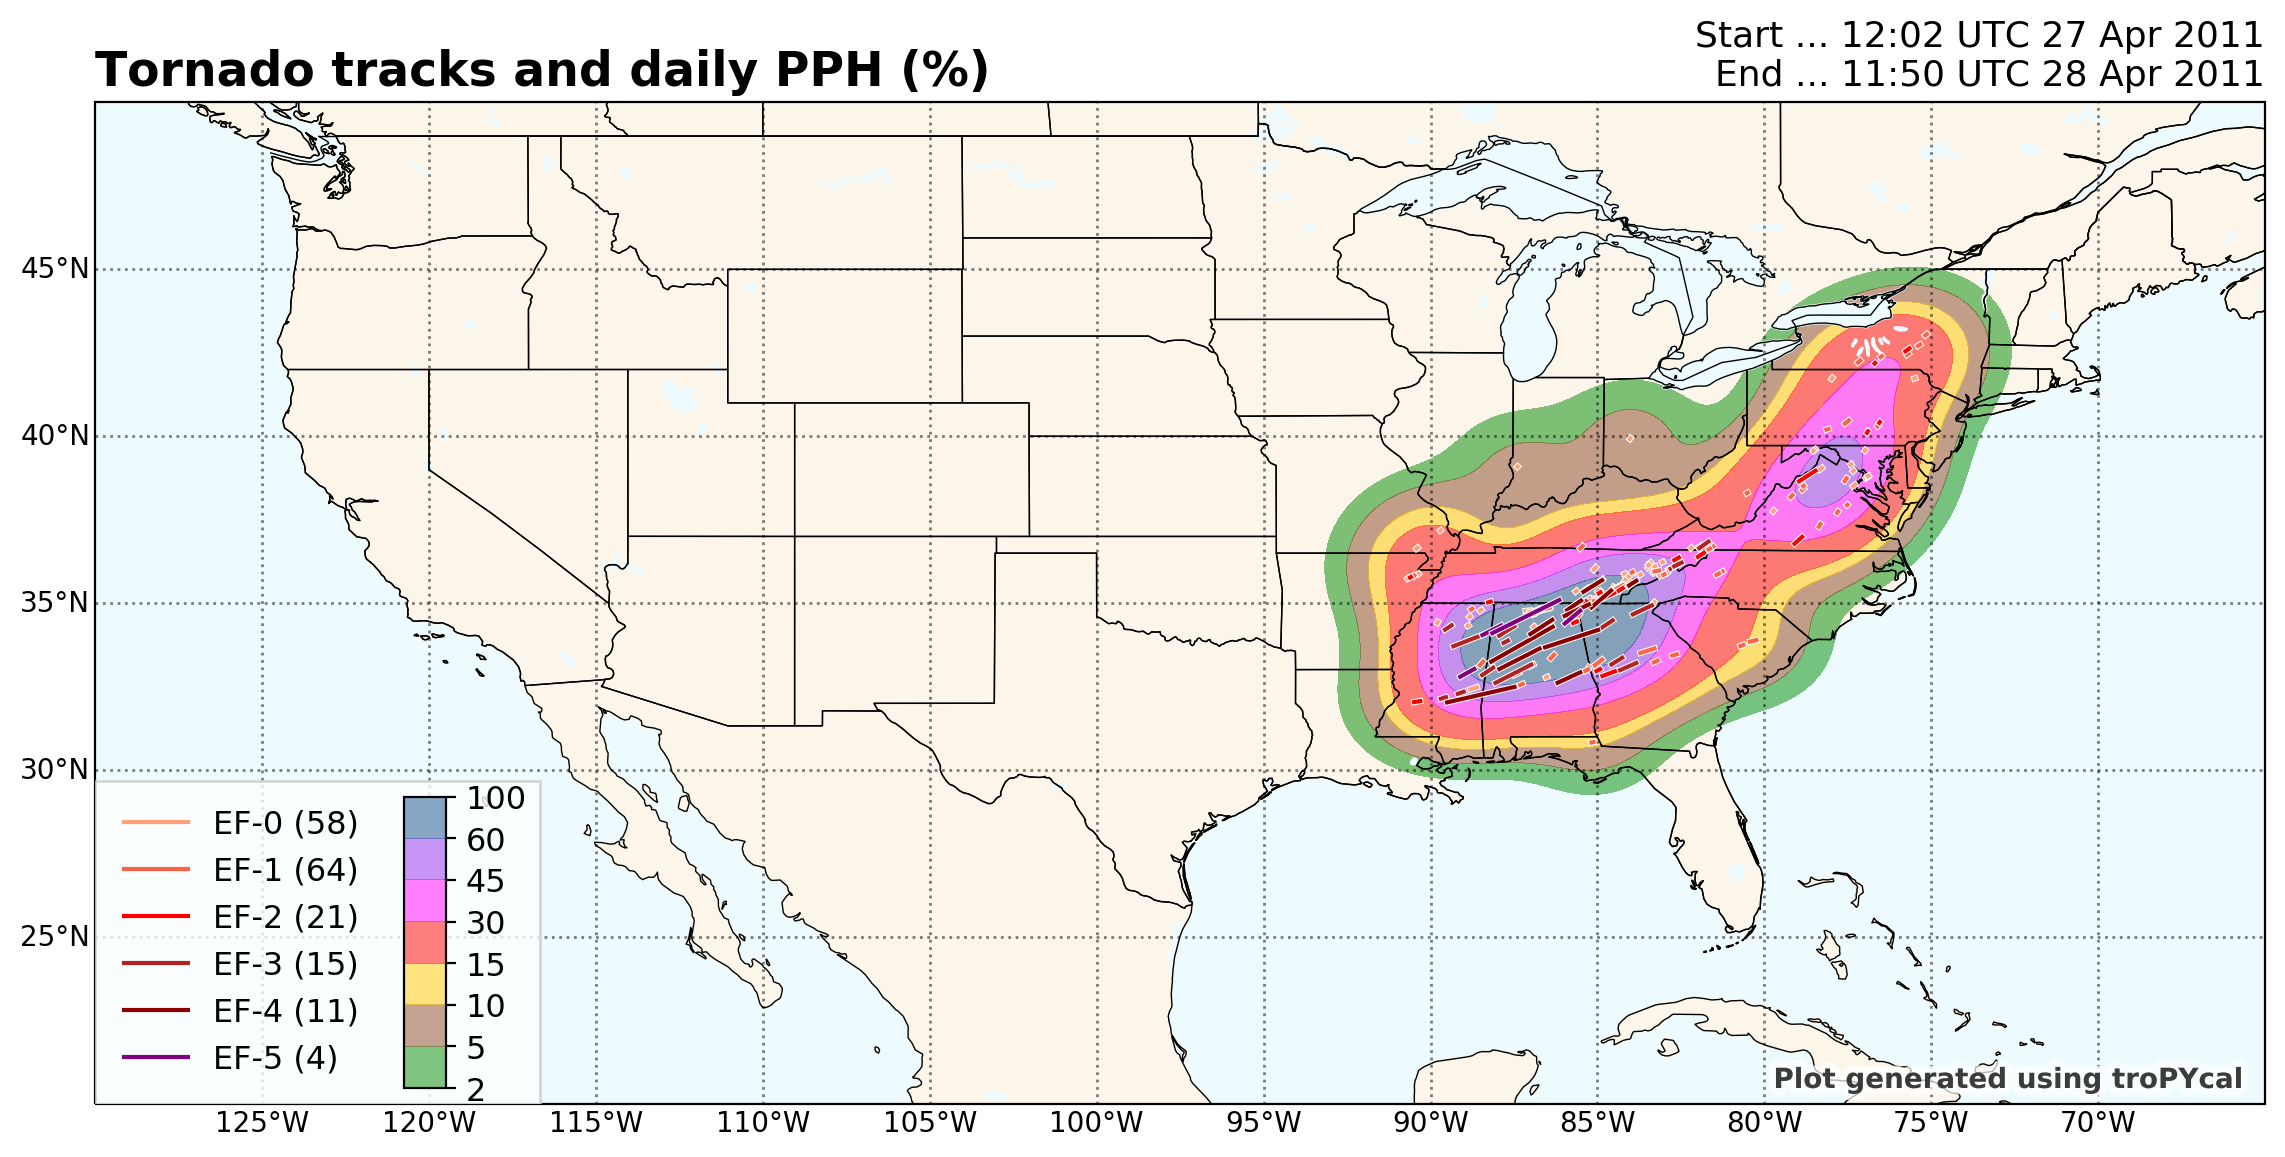

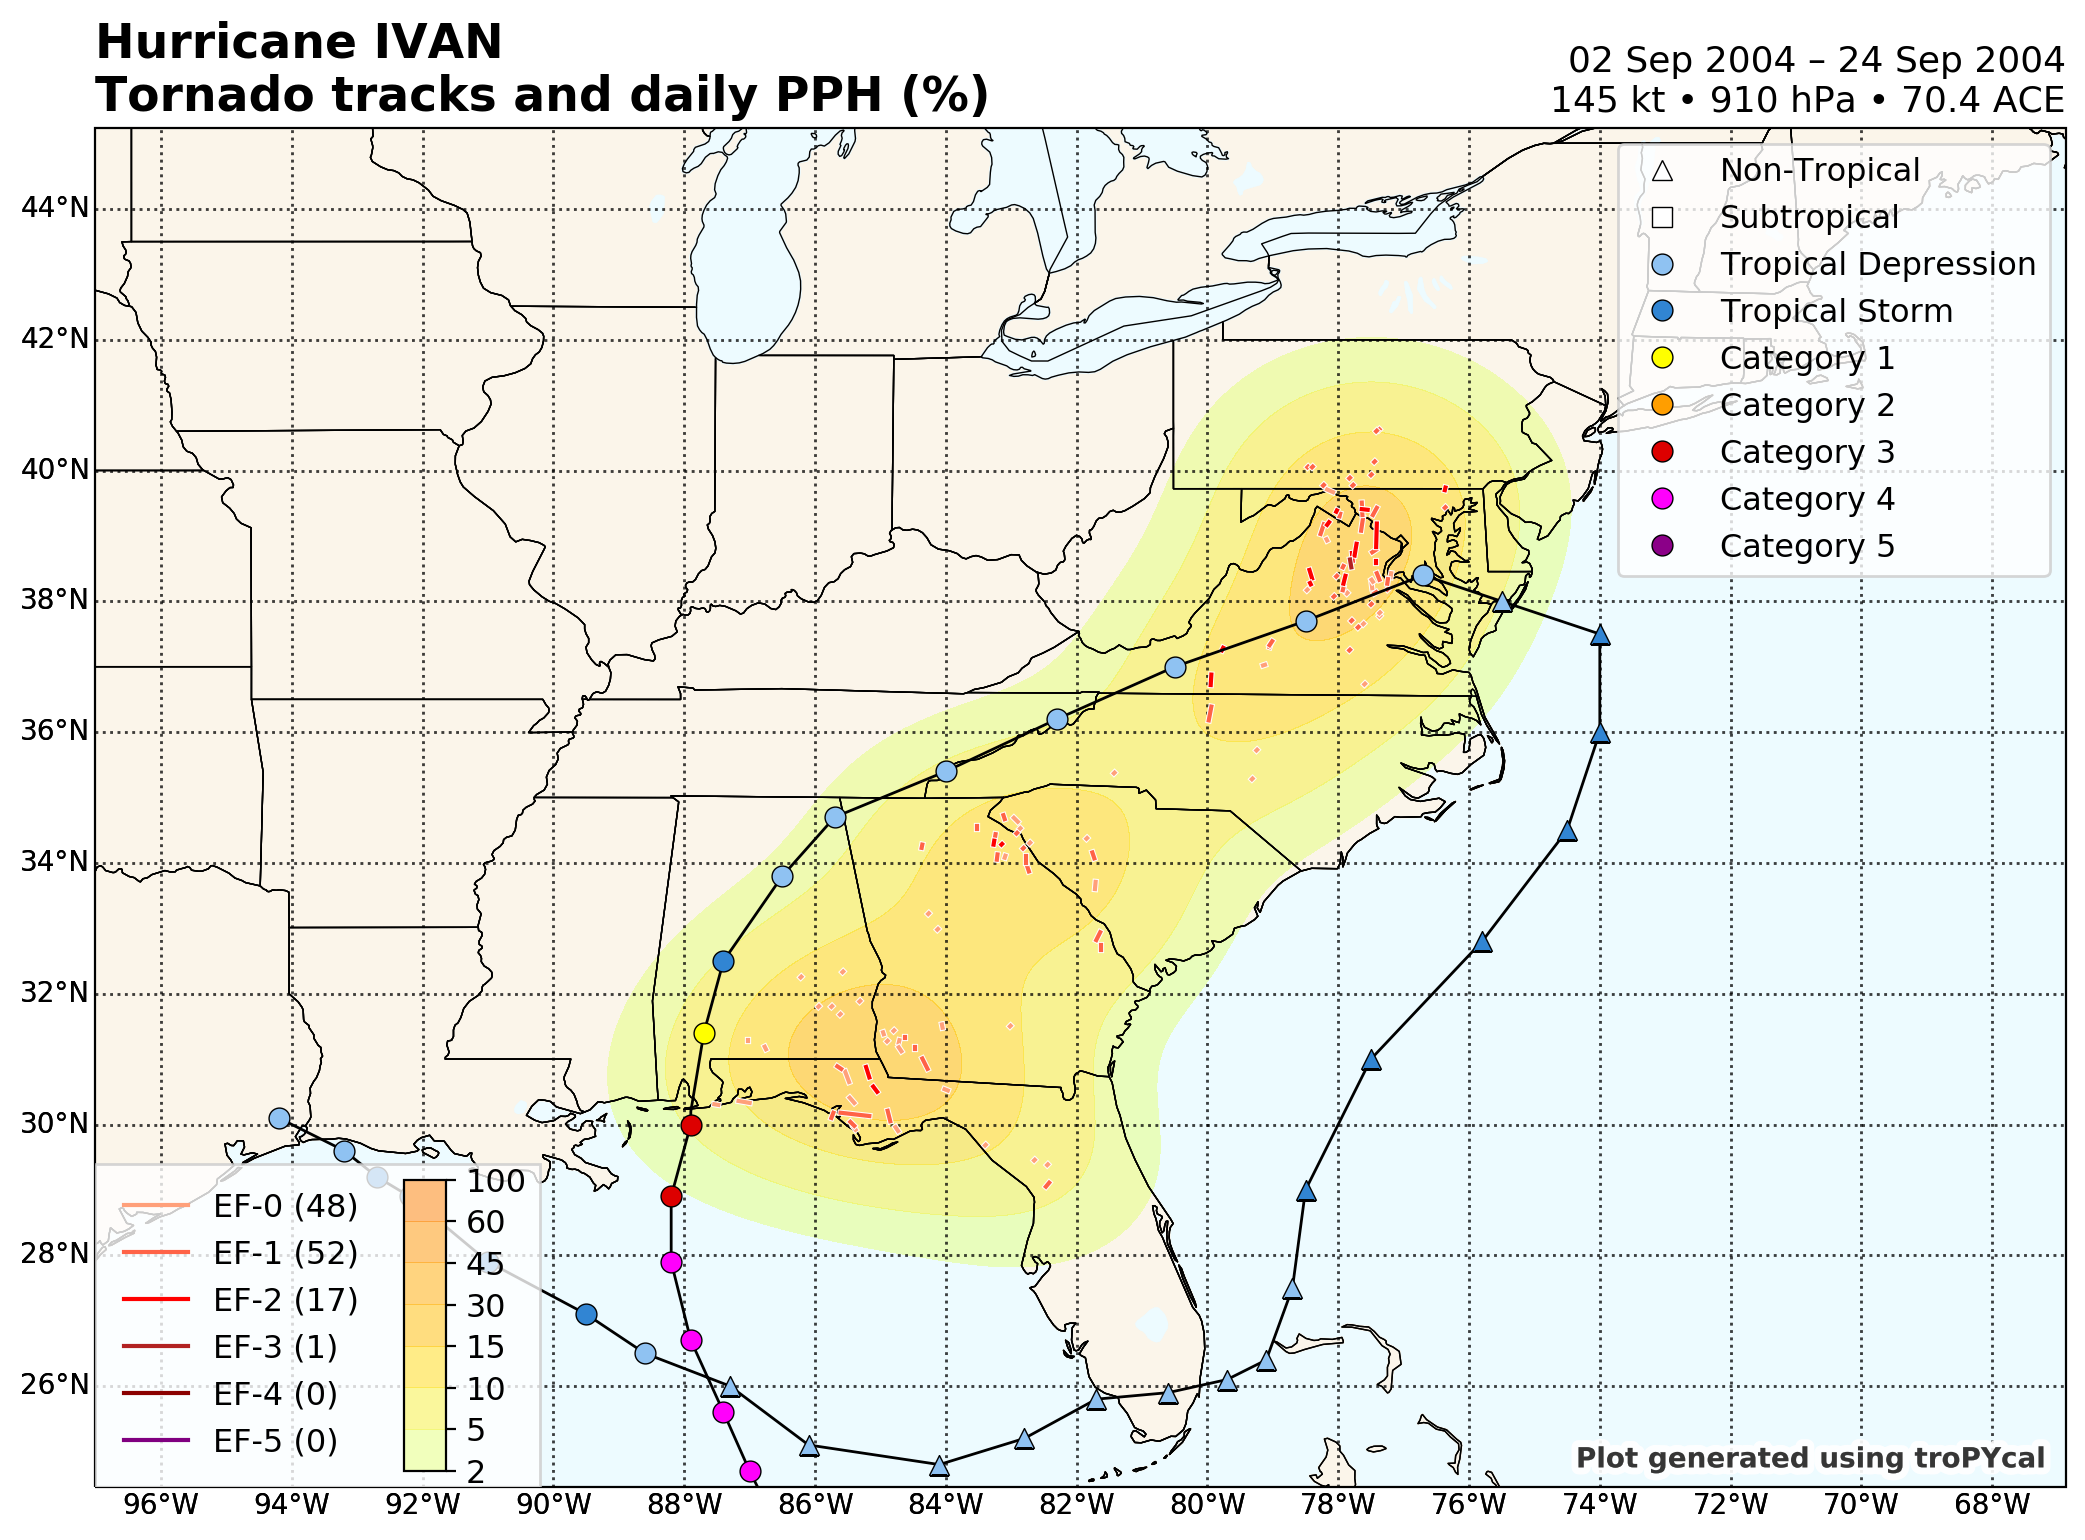

In [31]:
tor_data = tornado.TornadoDataset()

tor_ax,domain,leg_tor = tor_data.plot_tors(dt.datetime(2011,4,27),plotPPH=True,return_ax=True)
tor_ax

hurdat_atl = tracks.TrackDataset(basin='north_atlantic',source='hurdat',include_btk=False)
#
hurdat_atl.assign_storm_tornadoes(dist_thresh=750)
#
storm = hurdat_atl.get_storm(('ivan',2004))
#
storm.plot_tors(plotPPH=True,return_ax=True)


--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (10.66 seconds)
<tropycal.tracks.Storm>
Storm Summary:
    Maximum Wind:      140 knots
    Minimum Pressure:  919 hPa
    Start Date:        0600 UTC 07 October 2018
    End Date:          1800 UTC 11 October 2018

Variables:
    date        (datetime) [2018-10-06 18:00:00 .... 2018-10-15 18:00:00]
    extra_obs   (int32) [0 .... 0]
    special     (str) [ .... ]
    type        (str) [LO .... EX]
    lat         (float64) [17.8 .... 41.2]
    lon         (float64) [-86.6 .... -10.0]
    vmax        (int32) [25 .... 35]
    mslp        (int32) [1006 .... 1001]
    wmo_basin   (str) [north_atlantic .... north_atlantic]

More Information:
    id:              AL142018
    operational_id:  AL142018
    name:            MICHAEL
    year:            2018
    season:          2018
    basin:           north_atlantic
    source_info:     NHC Hurricane Database
    source:          hurdat
    ace:             12.5
    

C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


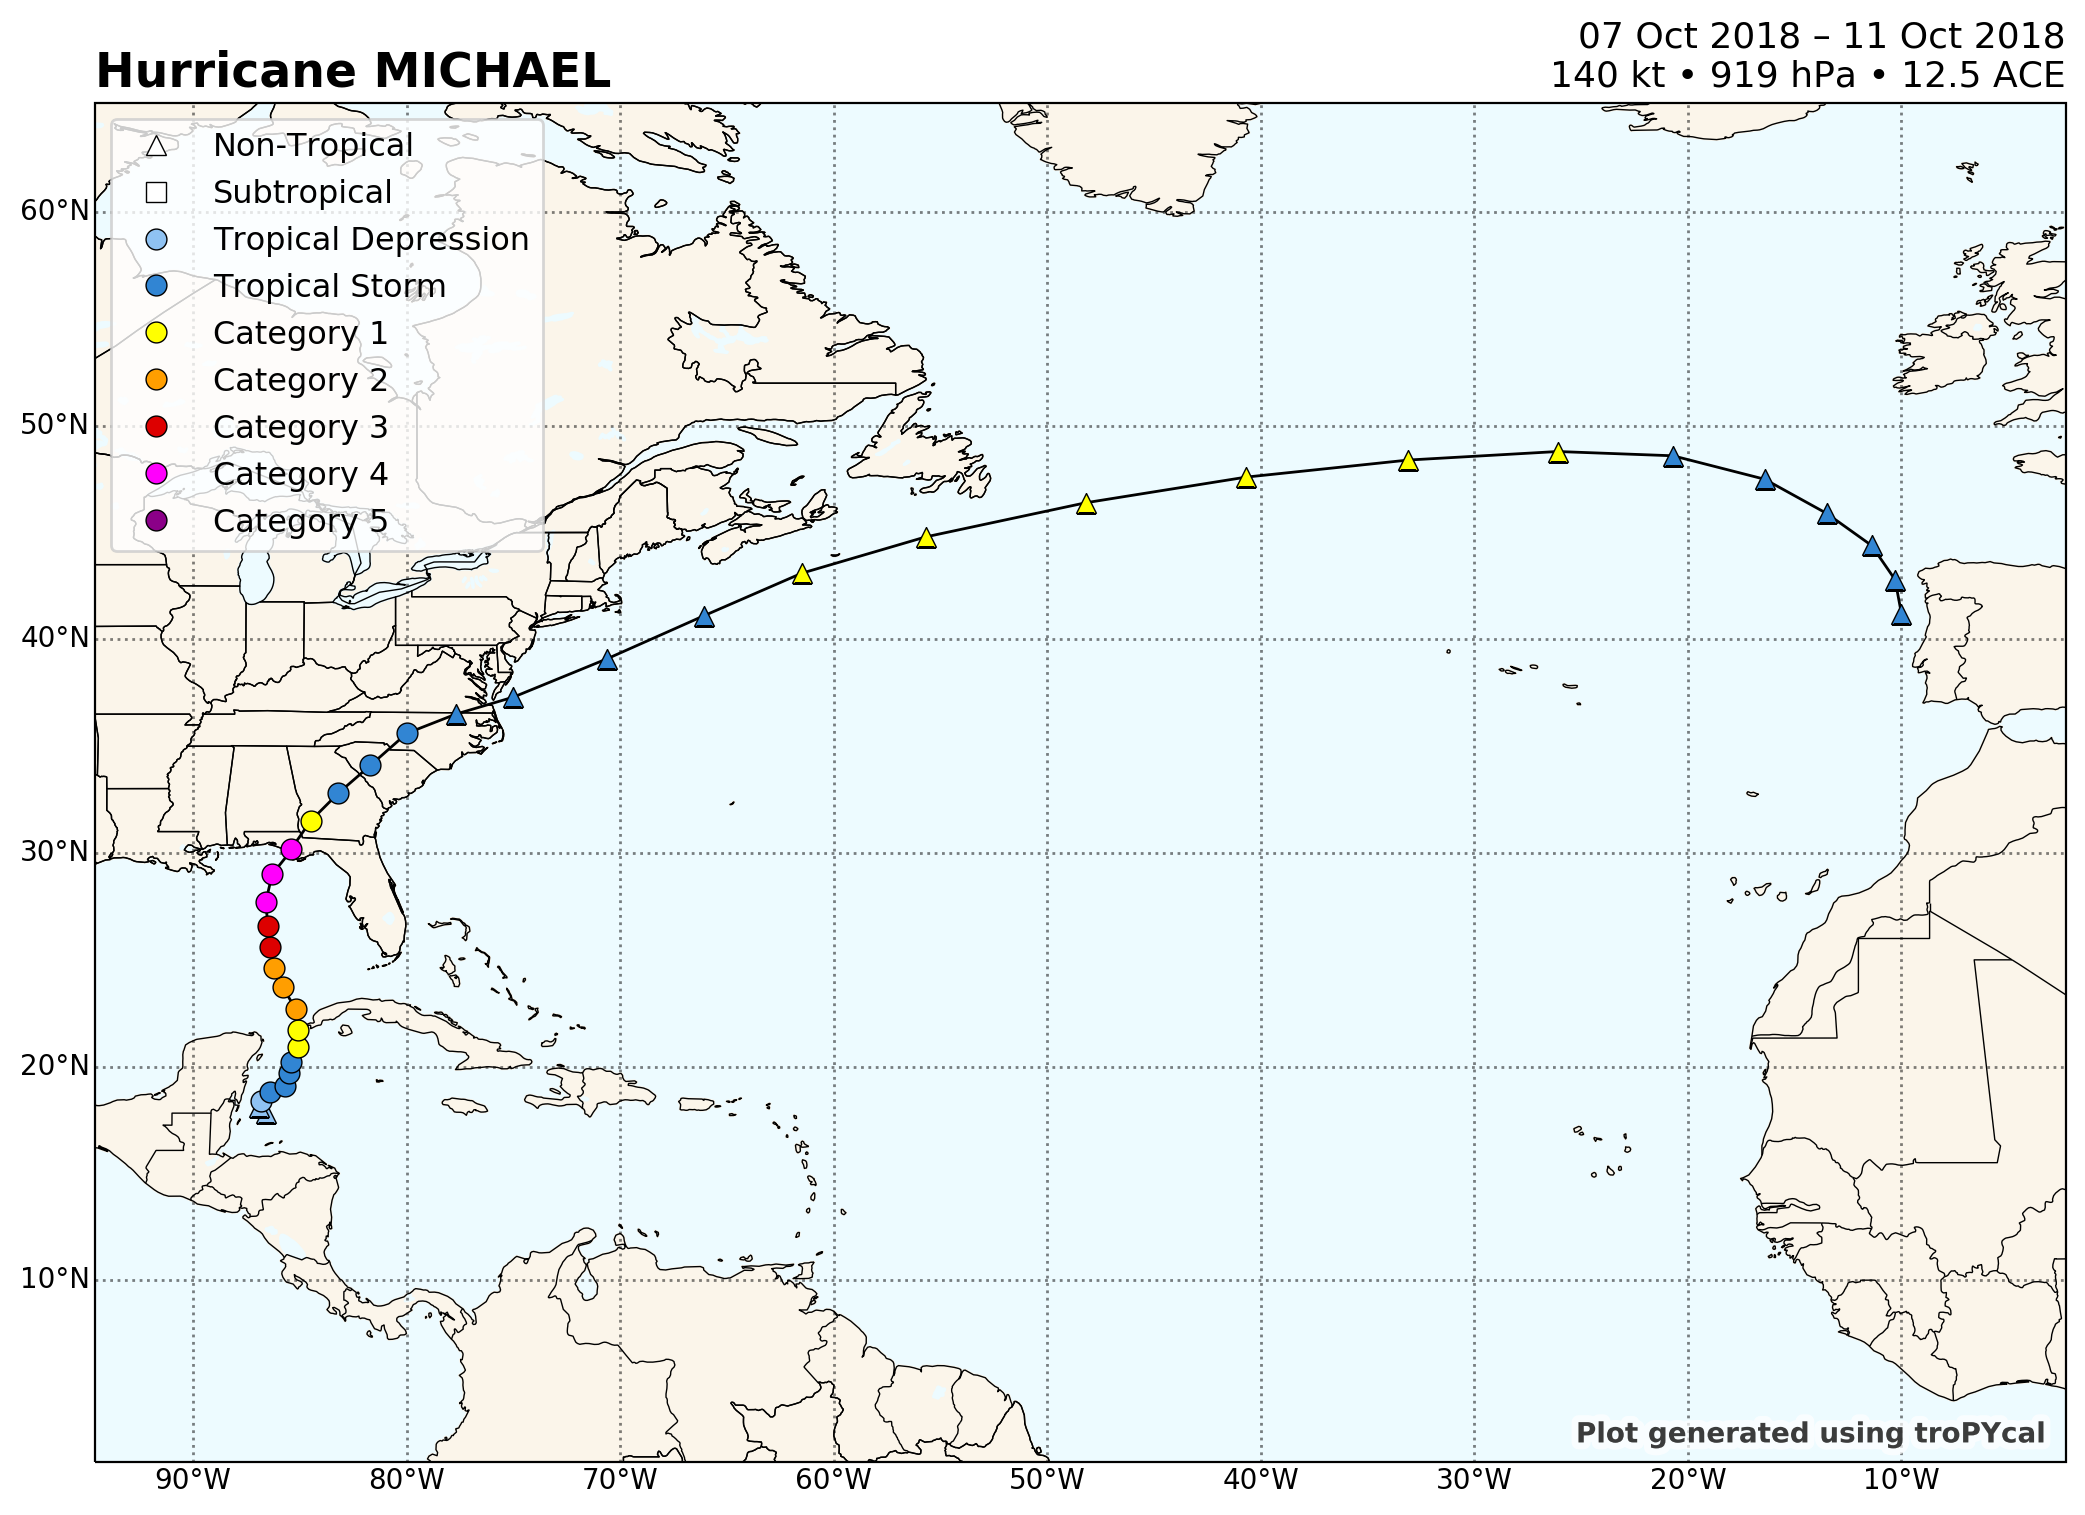

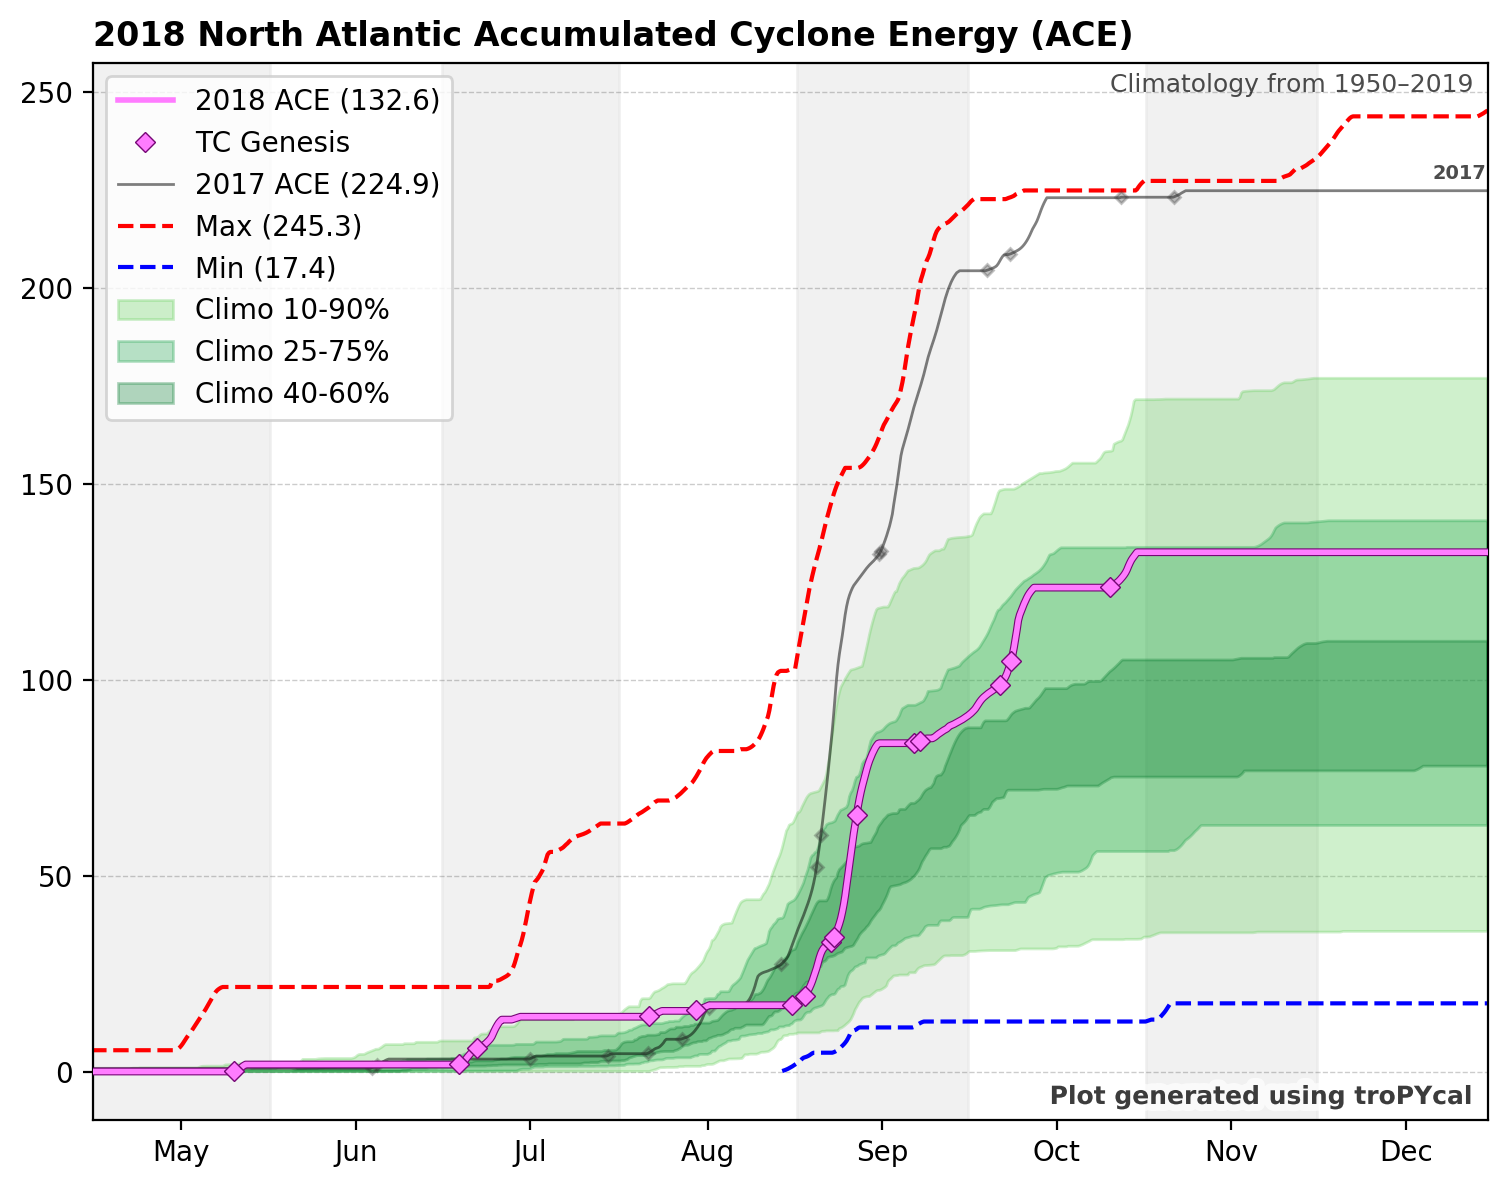

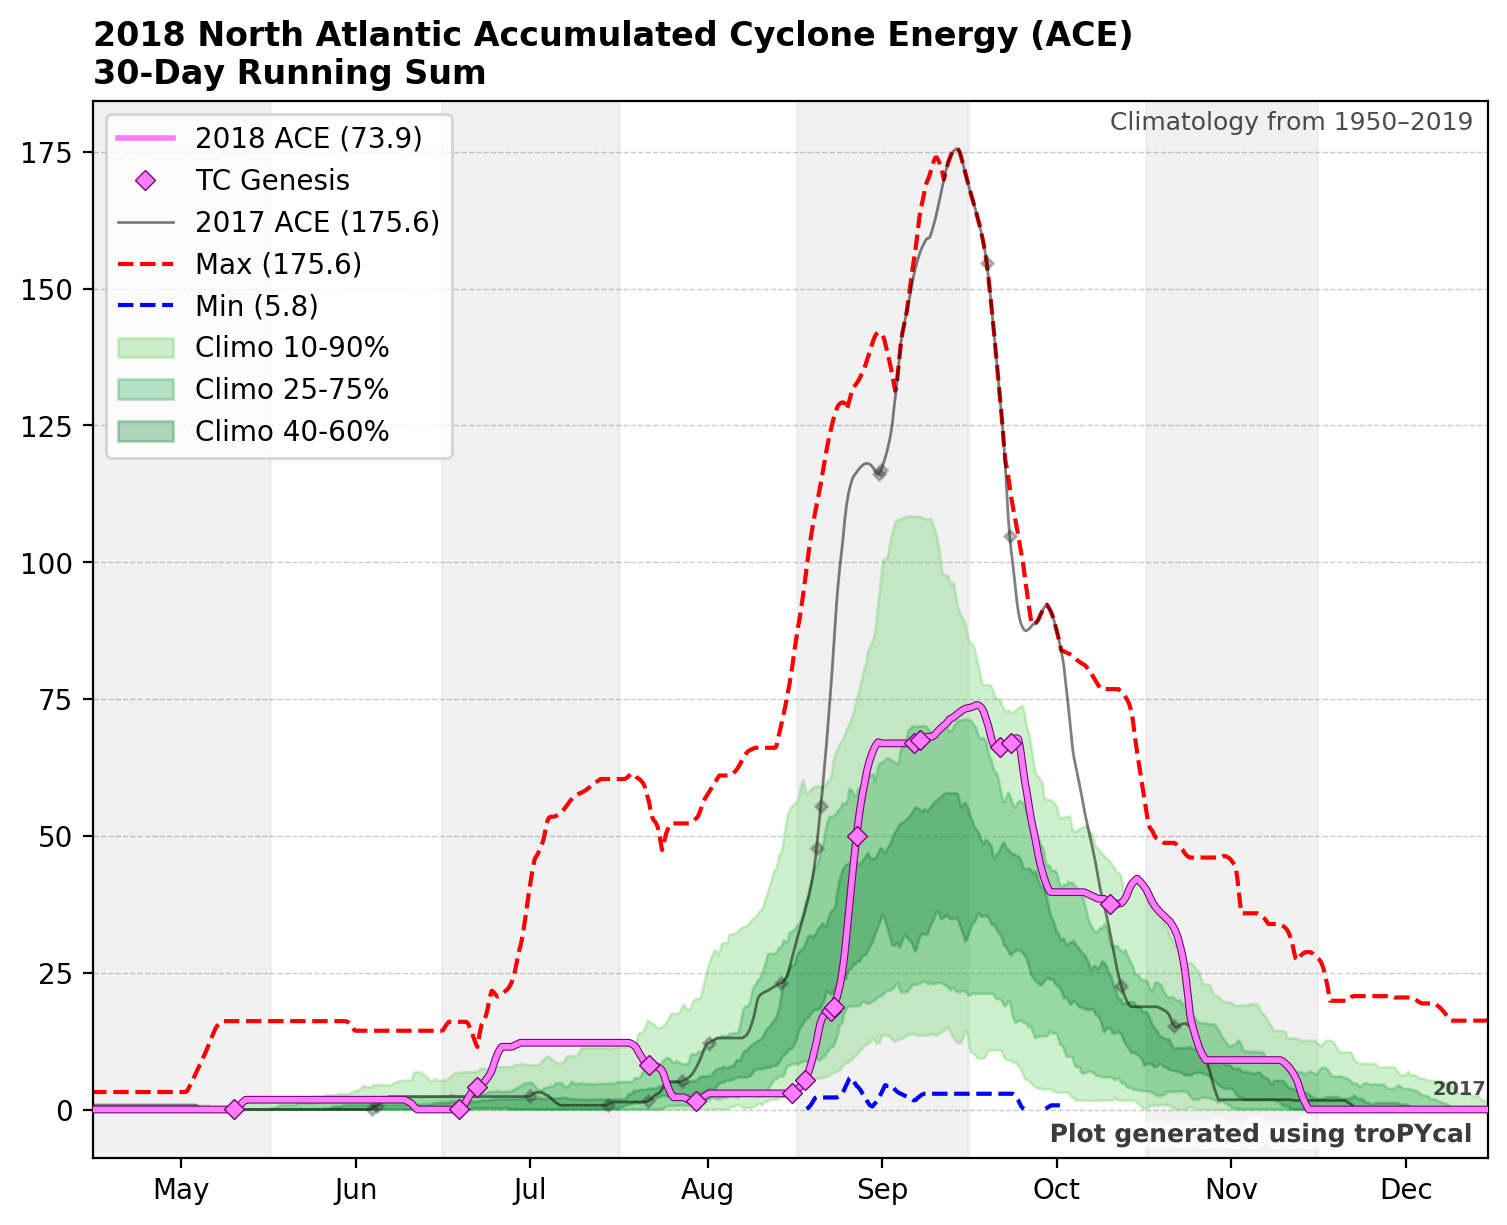

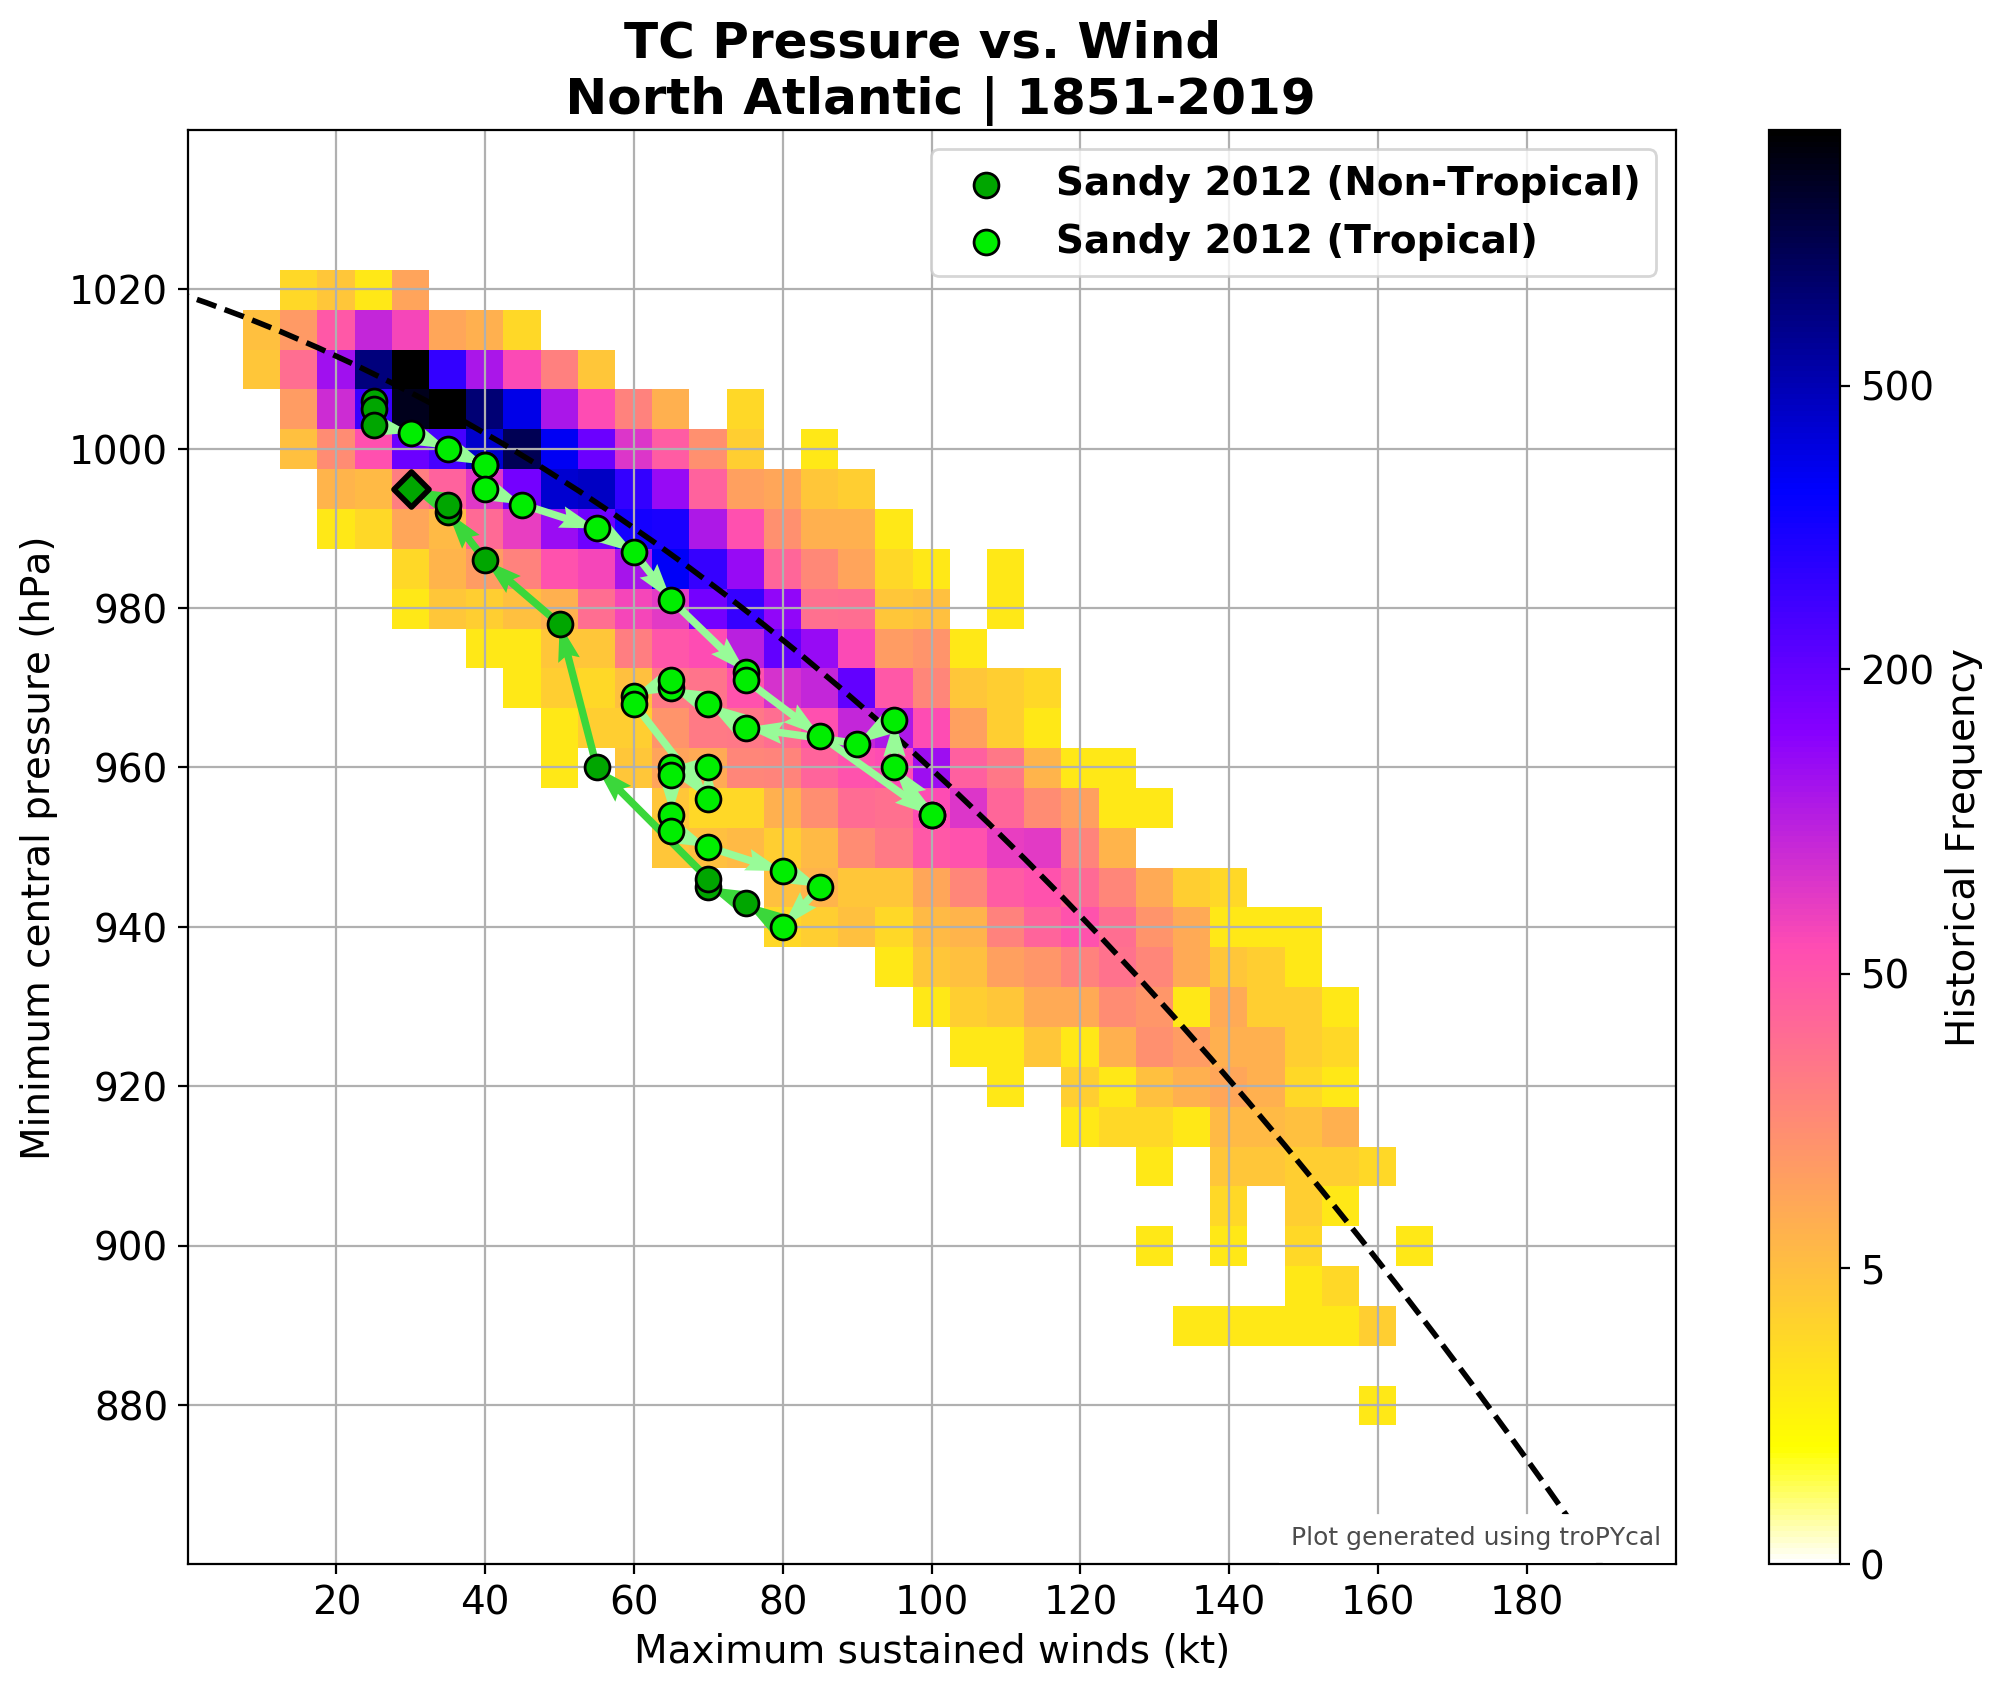

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (518.89 seconds)
--> Getting filtered storm tracks
--> Grouping by lat/lon/storm


C:\Users\User\anaconda3\lib\site-packages\tropycal\tracks\tools.py:101: RuntimeWarning: All-NaN slice encountered
  return thresh, lambda x: np.nanmax(x)
C:\Users\User\anaconda3\lib\site-packages\tropycal\tracks\tools.py:101: RuntimeWarning: All-NaN axis encountered
  return thresh, lambda x: np.nanmax(x)
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


--> Generating plot
--> Getting filtered storm tracks
--> Grouping by lat/lon/storm
--> Generating plot


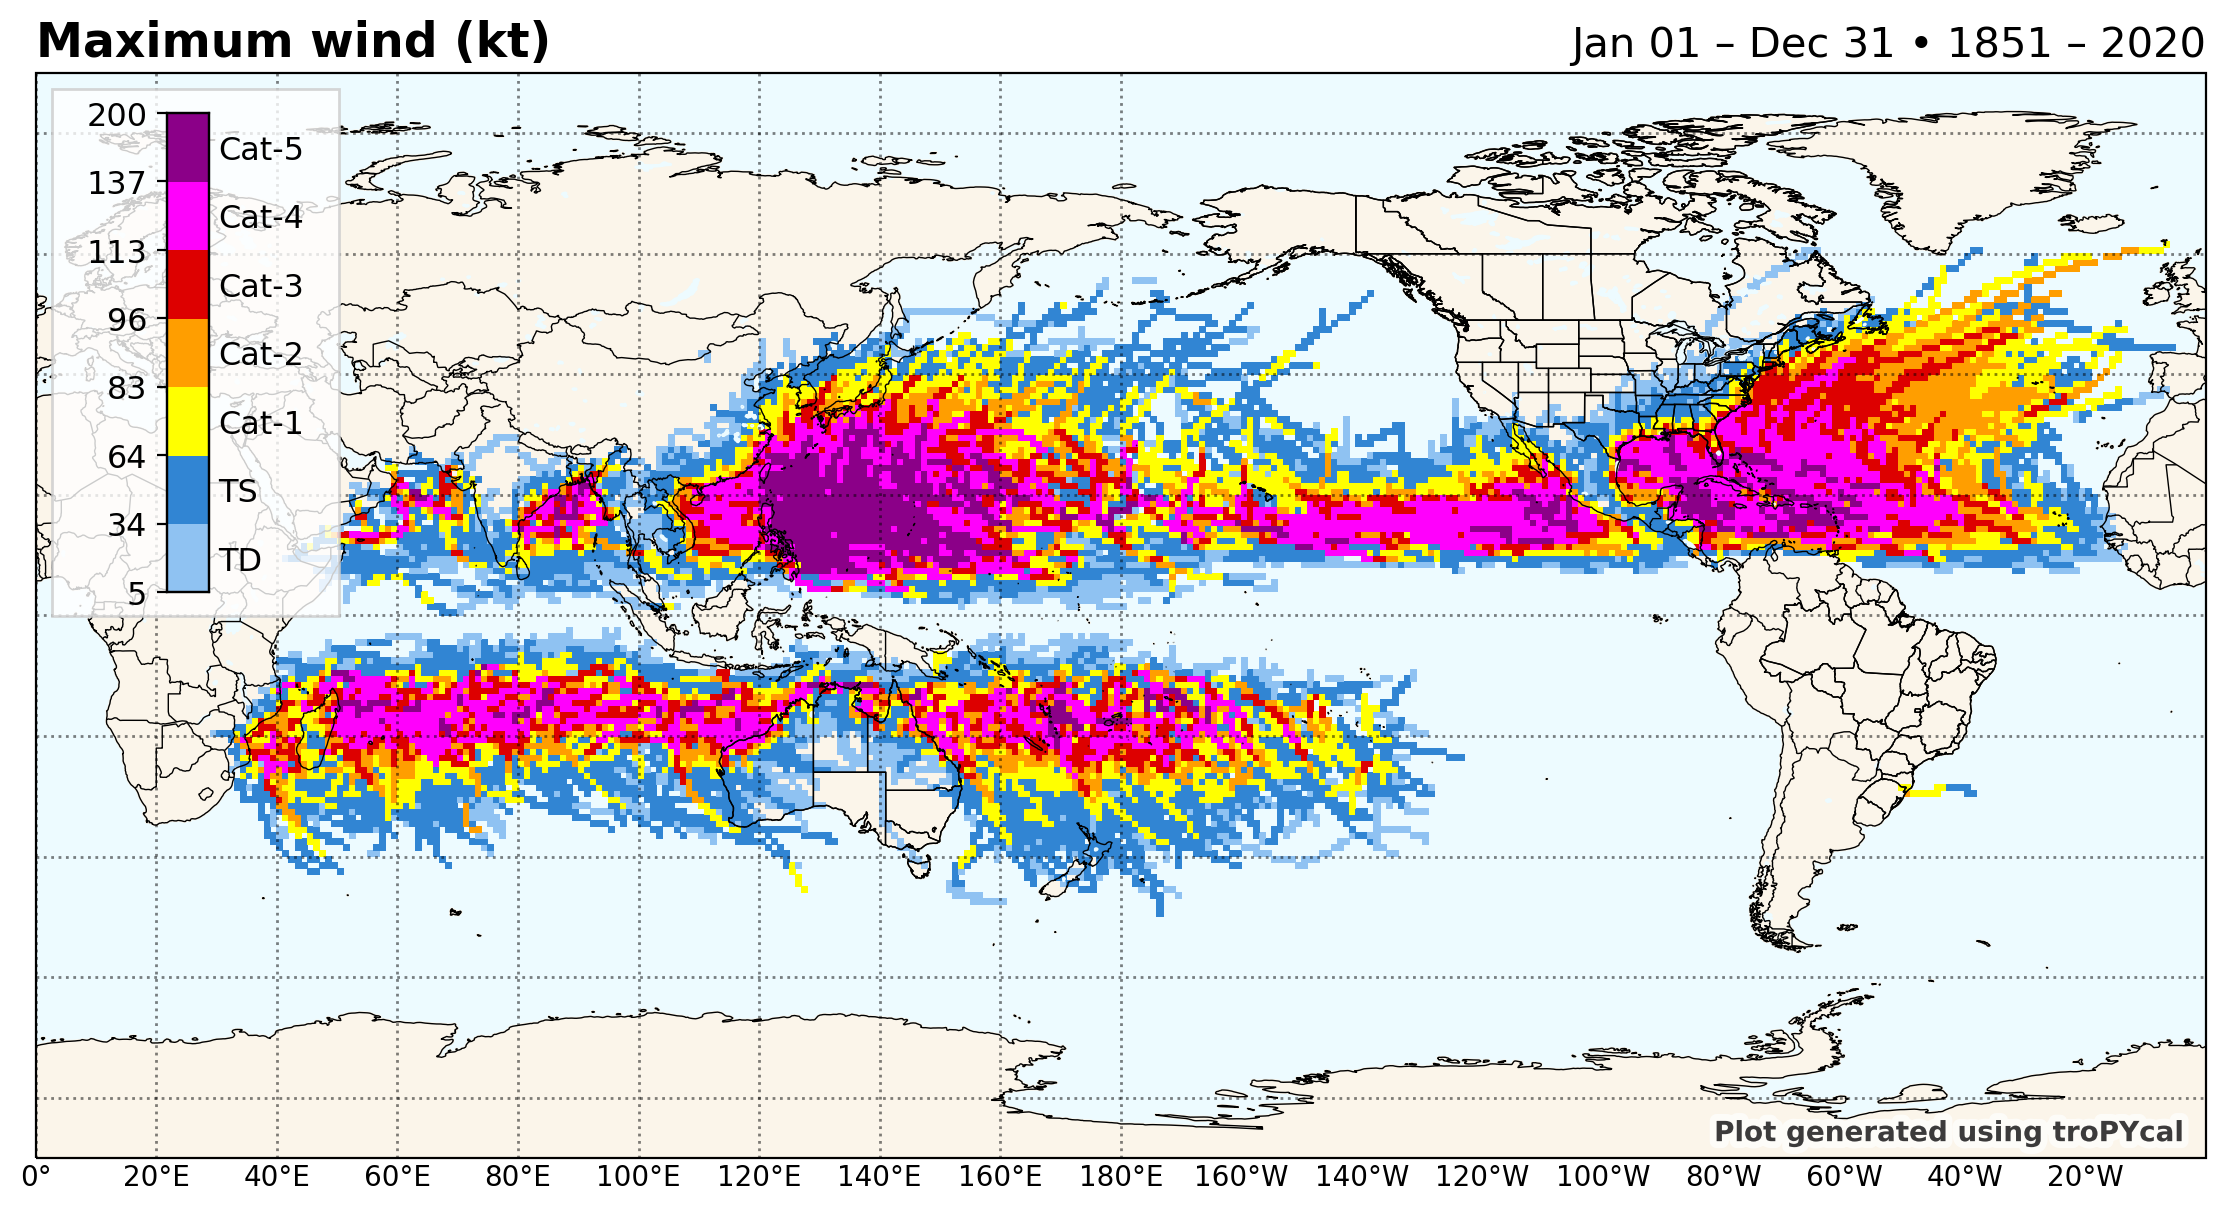

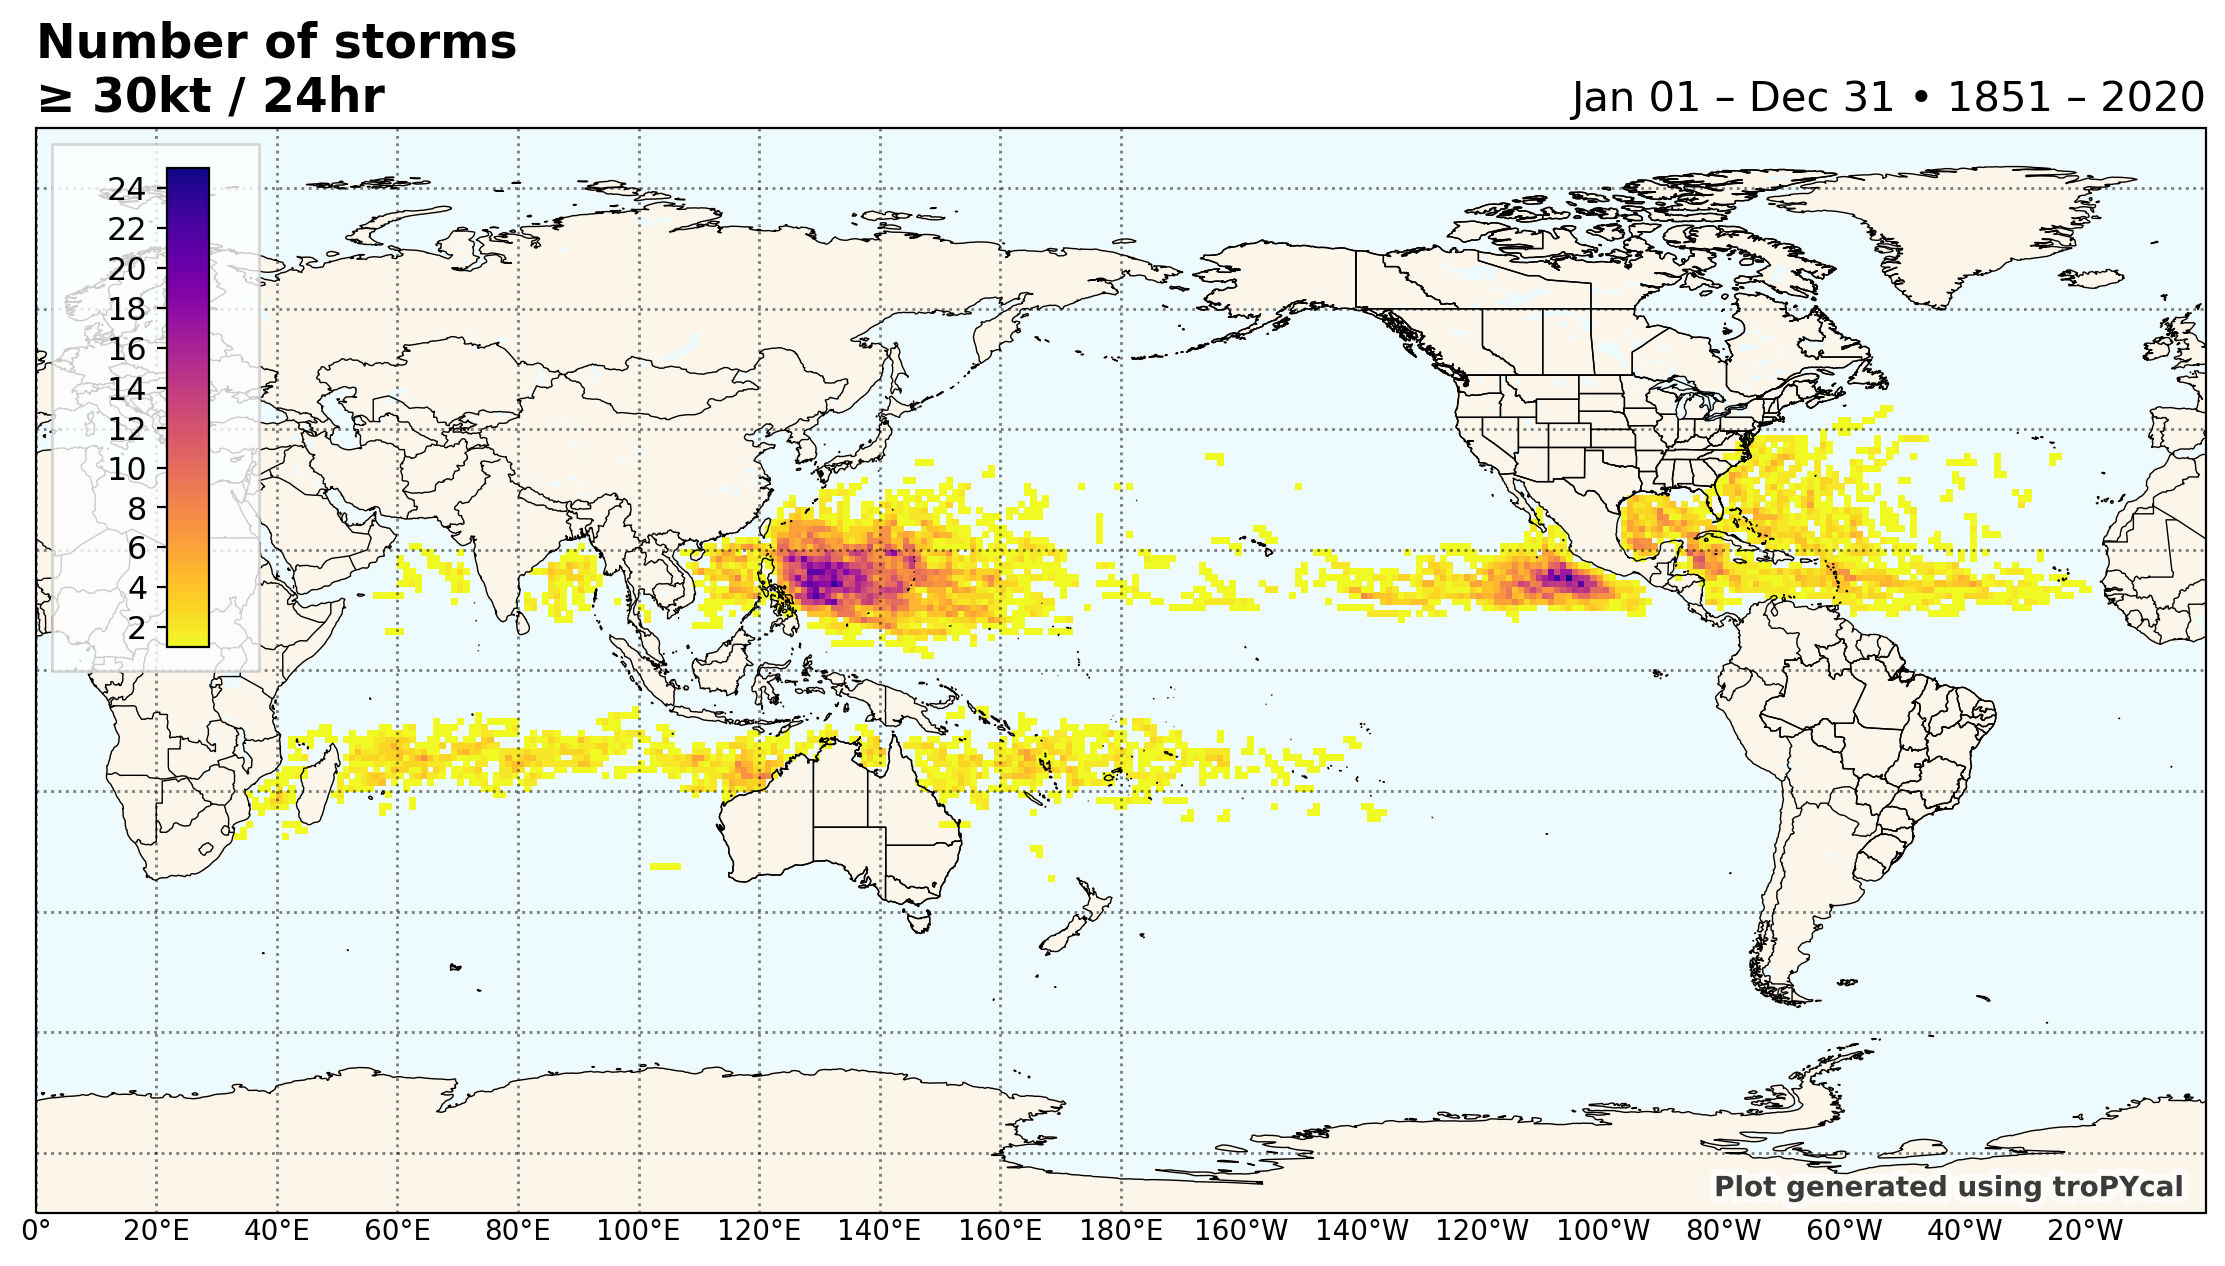

In [32]:
hurdat_atl = tracks.TrackDataset(basin='north_atlantic',source='hurdat',include_btk=False)

#Retrieve Hurricane Michael from 2018
storm = hurdat_atl.get_storm(('michael',2018))
    
#Retrieve the 2017 Atlantic hurricane season
season = hurdat_atl.get_season(2017)

#Printing the Storm object lists relevant data:
print(storm)
    
print(hurdat_atl.search_name('Michael'))
#
hurdat_atl.plot_storm(('michael',2018),return_ax=True)
#
hurdat_atl.ace_climo(plot_year=2018,compare_years=2017)
#
hurdat_atl.ace_climo(rolling_sum=30,plot_year=2018,compare_years=2017)
#
hurdat_atl.wind_pres_relationship(storm=('sandy',2012))
#
ibtracs = tracks.TrackDataset(basin='all',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True)
#
ibtracs.gridded_stats(request="maximum wind",return_ax=True)
#
ibtracs.gridded_stats(request="number of storms",thresh={'dv_min':30},prop={'cmap':'plasma_r'})
